## Table of Contents

* [1. Introduction](#introduction) 
* [2. Import Libraries and Data](#import) 
    * [2.1 Features Description](#features) 
* [3. RFM Segmentation](#rfm)
    * [3.1 Create summer_customers Dataframe](#create)
    * [3.2 Calculate Recency, Frequency, and Monetary Value for each Summer Customer](#calculaterfm)
    * [3.3 Clustering Recency using KMeans](#recency)
    * [3.4 Clustering Frequency using KMeans](#frequency)
    * [3.5 Clustering Monetary Value using KMeans](#monetary)
    * [3.6 Calculate Overall Score](#overall)
    * [3.7 Assign Low, Mid, and High Value Labels to Customers](#assign)
    * [3.8 Segment Vizualization](#segment)
    * [3.9 Merge RMF Data to Summer Users Dataframe](#merge)
* [4. Analyzing RFM Demographics](#analyzerfm)
* [5. Calculating Churn](#calculatechurn)
* [6. Analyzing Churn Demographics](#analyzechurn)
    * [6.1 By Sex](#bysex)
    * [6.2 By Customer Type](#bycustomer)
    * [6.3 By Age Group](#byage)
    * [6.4 By Income](#byincome)
    * [6.5 By Segment](#bysegment)
    * [6.6 By In-Game Features](#byfeatures)
* [7. Evaluating Effectiveness of Fall Bonus](#fallpromo)
    * [7.1 Hypothesis Test](#hypothesis)
* [8. Predicting Churn Rate](#churn)
    * [8.1 Feature Engineering](featureengineering)
    * [8.2 Designating Metrics and Choosing Models](#metrics)
    * [8.3 Defining Useful Functions](#functions)
    * [8.4 Data Pre Processing](#pre)
    * [8.5 Using Logistic Regression to find important features](#logimportant)
    * [8.6 Out of the Box Models](#ootb)
        * [8.6a Logistic Regression](#logreg)
        * [8.6b Random Forest](#randomforest)
        * [8.6c GradientBoost](#gradientboost)
        * [8.6d Catboost](#catboost)
        * [8.6e KNN](#knn)
    * [8.7 Hyperparameter Tuning and Feature Selection of Best Models](#hyperparameter)
        * [8.7a Random Forest](#randomtuned)
        * [8.7b Catboost](#cattuned)
   * [8.8 Model Selection](#modelselection)
* [9. Predicting Which Fall Players will Churn](#fallchurn)
* [10. Conclusions and Recommendations](#conclusions)
    

## Introduction

![](pokemon.jpg)

#### Background: 
After its release in 2016, the PokemonGo app hit the world by storm. After one day, it was already the highest grossing app and by the end of that year garnered over 832 million dollars in player spending with 2020 being its best performing year of over 1 biliion dollars in the first ten months. Downloading the app is free so the app's main revenue sources are the in-game purchases made by users to advance their gameplay. Needless to say, keeping players engaged and optimizing the in-game purchases are important. 

#### Problem Context:
*note: this is a fictional business problem*

Historically, the peak playing season for PokemonGo has been during the summer time followed by a drop off in players in the fall and winter seasons. To counterbalance this churn behavior, Niantic launched a “fall bonus” at the end of summer 2018 which included free items to be used in gameplay. Niantic recently invested in their analytics department to help with their goals to:
* Better understand customer segments and their financial value
* Analyse the factors that affect the churn rate
* Assess the effectiveness of the fall bonus
* Create a model to predict churn

#### Constraints within the Solution Space: 
The data will only include the customer and financial data (fictional) from the summer and fall seasons of 2018 pertaining to a group of customers in Europe. Note: the monetary units are Euros.



#### Sources:
https://www.marketwatch.com/story/how-pokemon-go-makes-money-2016-07-11
https://www.thehindu.com/sci-tech/technology/pokmon-go-earns-1-billion-revenue-in-2020-alone/article33021702.ece

#### Data:
https://github.com/leonard-henriquez/PokemonGo/tree/master/input

<a class="anchor" id="import"></a>

## Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime

In [2]:
#For Modeling
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
#from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import catboost
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.model_selection import RandomizedSearchCV
import imblearn
from sklearn.neighbors import KNeighborsClassifier

#For Metrics
from sklearn import metrics
from sklearn.metrics import average_precision_score
from scikitplot.metrics import plot_precision_recall, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, log_loss, classification_report, auc
from sklearn.dummy import DummyClassifier
from pprint import pprint



In [4]:
customerdata = pd.read_csv('customerdata.csv', index_col=0)
summerpurchases = pd.read_csv('summerfintrx.csv', index_col=0)
summersessions = pd.read_csv('summersesstrx.csv', index_col=0)
fallpurchases = pd.read_csv('fallfintrx.csv', index_col=0)
fallsessions = pd.read_csv('fallsesstrx.csv', index_col=0)

### Features Description

#### customerdata: contains player information
* CustomerID: unique number to identify player
* CustomerType: player profile(1=walker, 2=miscellaneous, 3=social raider, 4=catcher)
* RegistrationDate: date when the player first refistered to play the game. (Note that the game was launched in July 2016)
* Sex: gender of player (0=male, 1=female)
* Age: age of player
* Fallbonus: did the player receive a promo code on 31/08/2018 or not? (0=no, 1=yes)
* Income: estimated income level (1=low, 2=medium, 3=high) of the player in maximum spendable euros per month

#### summerpurchases: contains all summer microtransactions at the individual customer level
##### (period 01-05-2018 to 31-08-2018)

* TransID: unique code per microtransaction
* Date: date at which the microtransaction occurred
* CustomerID: unique number to identify player
* ProductID: code corresponding to a financial value matching the transaction in euros (1=2.99, 2=4.99, 3=9.99, 4=25, 5=99)

#### summersessions: play sessions at the individual customer level
##### (period 01-05-2018 to 31-08-2018)
* PlayID: unique code per play session
* Date: date at which a play session started
* CustomerID: unique number to identify player
* Experience: amount of experience points the player collected during the session
* Pokestops: amount of Pokestops the player spinned during the session
* Gyms: amount of gyms the player interacted with during the session
* Raids: amount of raids the player performed during the session
* Social: amount of social actions the player performed during the session
* Pokemon: amount of wild Pokemon the player caught during the session
* Duration: The duration in minutes per play session

Note: a session starts when a player logs into the game and ends when the connection with the server is lost or at the end of the day. It is possible for a player to have multiple sessions recorded per day.

#### fallpurchases and fallsessions
use the same variables as their summer equivalents, but during the period 01-09-2018 to 31-10-2018

<a class="anchor" id="rfm"></a>

## RFM Segmentation

We want to create an RFM segmentation using the financial data over the course of the summer season. Let's make sure there is no missing data.

In [5]:
summerpurchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2231 entries, 1 to 2231
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   TransID     2231 non-null   int64 
 1   Date        2231 non-null   object
 2   CustomerID  2231 non-null   int64 
 3   ProductID   2231 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 87.1+ KB


In [6]:
#customerdata = pd.read_csv('customerdata.csv', index_col=0)
#customerdata_rfm = pd.read_csv('customerdata_rfm.csv', index_col=0)
#summerpurchases = pd.read_csv('summerfintrx.csv', index_col=0)
#summersessions = pd.read_csv('summersesstrx.csv', index_col=0)
#fallpurchases = pd.read_csv('fallfintrx.csv', index_col=0)
#fallsessions = pd.read_csv('fallsesstrx.csv', index_col=0)
#rfm = pd.read_csv('rfm.csv')

In [7]:
import warnings
warnings.filterwarnings("ignore")

<a class="anchor" id="create"></a>


### Create summer_customers DataFrame

In [8]:
#Create Summer Sessions Count DF (will become column in summer_customers dataframe)

SummerSessionsCount = summersessions.groupby('CustomerID').count()
SummerSessionsCount = SummerSessionsCount.drop(columns=['Date','Experience','Pokestops','Gyms','Raids','Social','Pokemons','Distance','Duration'])

                    
                    

In [9]:
#Create Summer Avgs DF with the average play factors (will become columns in summer_customers dataframe)
summer_avgs = summersessions.groupby('CustomerID').mean()

In [10]:
#merge SummerSessionsCount df with customer df to create summer_users df
summer_users = customerdata.merge(SummerSessionsCount, on='CustomerID', how='right')

#merge summer_avgs to summer_users df
summer_users = summer_users.merge(summer_avgs, on='CustomerID', how='right')

In [11]:
#drop PlayID_y column (this column is the average PlayID which is useless)
summer_users = summer_users.drop(columns='PlayID_y')

In [12]:
#rename PlayID_x (which is the number of times the customer played in the summer)
summer_users = summer_users.rename(columns={"PlayID_x":"SummerSessionsCount"})

In [13]:
summer_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4717 entries, 0 to 4716
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           4717 non-null   int64  
 1   CustomerType         4717 non-null   int64  
 2   Registrationdate     4717 non-null   object 
 3   Sex                  4717 non-null   int64  
 4   Age                  4717 non-null   int64  
 5   fallbonus            4717 non-null   int64  
 6   Income               4717 non-null   int64  
 7   SummerSessionsCount  4717 non-null   int64  
 8   Experience           4717 non-null   float64
 9   Pokestops            4717 non-null   float64
 10  Gyms                 4717 non-null   float64
 11  Raids                4717 non-null   float64
 12  Social               4717 non-null   float64
 13  Pokemons             4717 non-null   float64
 14  Distance             4717 non-null   float64
 15  Duration             4717 non-null   f

<a class="anchor" id="calculaterfm"></a>


## Calculate Revenue, Frequency, and Monetary Value for each Summer Customer

In [14]:
print('Min:{};Max:{}'.format(min(summerpurchases.Date), max(summerpurchases.Date)))

Min:2018-05-02;Max:2018-08-31


We are going to assume that we are completing this analysis on up-to-date data. Since our data collection ended on August 31, 2018 we will create our snapshot date to be September 1, 2018 when computing Days Since Last Purchase for our Recency column. Before we do that we will need to convert our Date column into a DateTime column.

In [15]:
summerpurchases['Date']= pd.to_datetime(summerpurchases['Date'])

In [16]:
snapshot_date = max(summerpurchases.Date) + datetime.timedelta(days=1)

Because the amount spent has been coded in the ProductID column, and I want to know total amount of euros spent per customer, I will de-code this column into a new column, Revenue.

In [17]:
#create Revenue column for each purchase based on the ProductID column:
def Revenue(df):

    if (df['ProductID'] == 1):
        return 2.99
    elif (df['ProductID'] == 2):
        return 4.99
    elif(df['ProductID'] ==3):
        return 9.99
    elif(df['ProductID'] ==4):
        return 25
    else:
        return 99


#check out updated df
summerpurchases['Revenue'] = summerpurchases.apply(Revenue, axis = 1)
summerpurchases.head()

,TransID,Date,CustomerID,ProductID,Revenue
1,1,2018-05-02,3864,5,99.00
2,2,2018-05-02,2172,1,2.99
3,3,2018-05-02,1287,1,2.99
4,4,2018-05-02,1677,1,2.99
5,5,2018-05-02,705,1,2.99


In [18]:
#Aggregate data on a customer level

summer_rfm = summerpurchases.groupby(['CustomerID']).agg({
    'Date' : lambda x: (snapshot_date - x.max()).days,
    'ProductID' : 'count',
    'Revenue': 'sum'
})

#Rename columns for easier interpretation
summer_rfm.rename(columns = {'Date': 'Recency',
                      'ProductID': 'Frequency',
                      'Revenue': 'MonetaryValue'
                     }, inplace=True)

In [19]:
summer_rfm['CustomerID'] = summer_rfm.index
summer_rfm

,Recency,Frequency,MonetaryValue,CustomerID
CustomerID,,,,
4,11,2,7.98,4
6,94,1,2.99,6
8,20,3,14.97,8
9,38,1,2.99,9
11,85,1,2.99,11
...,...,...,...,...
4995,82,1,4.99,4995
4996,32,2,5.98,4996
4997,28,1,4.99,4997


As we can see by the number of rows, out of the 4717 PokemonGo players over the summer period, only 1711 of them made any purchases in the app.

<a class="anchor" id="recency"></a>


### Clustering Recency using Kmeans

In [20]:
summer_rfm.Recency.describe()

count    1711.000000
mean       57.266511
std        34.424428
min         1.000000
25%        27.000000
50%        55.000000
75%        86.000000
max       122.000000
Name: Recency, dtype: float64

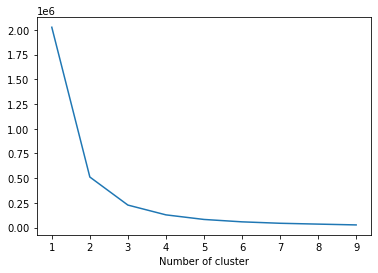

In [21]:
from sklearn.cluster import KMeans

sse={}
pg_recency = summer_rfm[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(pg_recency)
    pg_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [22]:
#build 3 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(summer_rfm[['Recency']])
summer_rfm['RecencyCluster'] = kmeans.predict(summer_rfm[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

summer_rfm = order_cluster('RecencyCluster', 'Recency',summer_rfm,False)

Let's check out some information on our clusters

In [23]:
mapping = {0:1, 1:2, 2:3}
summer_rfm['RecencyCluster'] = [mapping[i] for i in summer_rfm['RecencyCluster']]

In [24]:
summer_rfm.groupby('RecencyCluster')['Recency'].describe()


,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
1,509.0,100.369352,12.180933,80.0,90.0,100.0,111.00,122.0
2,584.0,58.979452,11.678494,40.0,49.0,59.0,69.00,79.0
3,618.0,20.147249,10.852302,1.0,11.0,20.0,29.75,39.0


Our clusters are close in size which is good. You can see that we assigned the higher cluster value (2 in this case) to the cluster with the lowest Recency mean. This means cluster 2 are the customers that purchased something off the app most recently.

<a class="anchor" id="frequency"></a>


### Clustering Frequency using K means

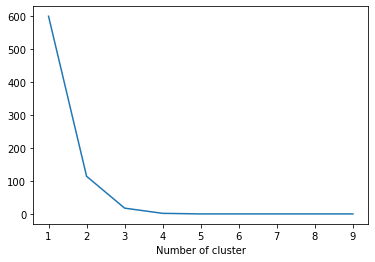

In [25]:
sse={}
pg_frequency = summer_rfm[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(pg_frequency)
    pg_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

The result seems to suggest that 3 segments would be best here. We will do the same thing as above by assigning our data to the 3 clusters and storing the information under the FrequencyCluster column.

In [26]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(summer_rfm[['Frequency']])
summer_rfm['FrequencyCluster'] = kmeans.predict(summer_rfm[['Frequency']])

In [27]:
summer_rfm = order_cluster('FrequencyCluster', 'Frequency',summer_rfm,True)

In [28]:
mapping = {0:1, 1:2, 2:3}
summer_rfm['FrequencyCluster'] = [mapping[i] for i in summer_rfm['FrequencyCluster']]

In [29]:
summer_rfm.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
1,1291.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
2,337.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
3,83.0,3.204819,0.462207,3.0,3.0,3.0,3.0,5.0


Because the customers in our dataset have only ever purchased less than 5 products, our data is forced to be a little bit uneven. 1291 customers only purchased one product so this cluster is our largest.

<a class="anchor" id="monetary"></a>

### Clustering Monetary Value using K Means

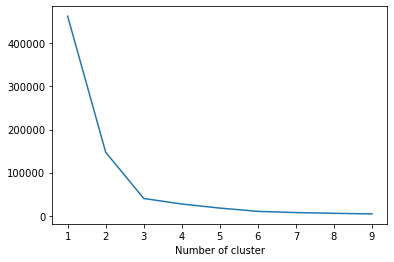

In [30]:
sse={}
pg_monetaryvalue = summer_rfm[['MonetaryValue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(pg_monetaryvalue)
    pg_monetaryvalue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [31]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(summer_rfm[['MonetaryValue']])
summer_rfm['MonetaryValueCluster'] = kmeans.predict(summer_rfm[['MonetaryValue']])

In [32]:
summer_rfm = order_cluster('MonetaryValueCluster', 'MonetaryValue',summer_rfm,True)

mapping = {0:1, 1:2, 2:3}
summer_rfm['MonetaryValueCluster'] = [mapping[i] for i in summer_rfm['MonetaryValueCluster']]

summer_rfm.groupby('MonetaryValueCluster')['MonetaryValue'].describe()


,count,mean,std,min,25%,50%,75%,max
MonetaryValueCluster,,,,,,,,
1,1395.0,5.962065,3.349870,2.99,2.99,4.99,7.98,15.97
2,281.0,27.415196,6.523866,17.96,25.00,25.00,27.99,59.99
3,35.0,105.422571,19.153308,69.98,99.00,99.00,106.98,200.99


<a class="anchor" id="overall"></a>

### Calculate Overall Score

In [33]:
summer_rfm['OverallScore'] = summer_rfm['RecencyCluster'] + summer_rfm['FrequencyCluster'] + summer_rfm['MonetaryValueCluster']


In [34]:
summer_rfm.groupby('OverallScore')['Recency','Frequency','MonetaryValue'].mean()


,Recency,Frequency,MonetaryValue
OverallScore,,,
3,100.992405,1.000000,5.081139
4,66.935897,1.074786,7.449786
5,33.296593,1.188377,9.638677
6,30.896552,1.844828,20.567112
7,27.701299,2.363636,32.489091
8,21.722222,3.277778,44.031111
9,16.750000,3.000000,137.235000


In [35]:
summer_rfm.groupby('OverallScore')['Recency'].count()

OverallScore
3    395
4    468
5    499
6    232
7     77
8     36
9      4
Name: Recency, dtype: int64

<a class="anchor" id="assign"></a>

### Assign Low, Mid, and High Value Labels to Customers

In [36]:
summer_rfm['Segment'] = 'Low_Value'
summer_rfm.loc[summer_rfm['OverallScore']>4,'Segment'] = 'Mid_Value' 
summer_rfm.loc[summer_rfm['OverallScore']>6,'Segment'] = 'High_Value'

In [37]:
summer_rfm.Segment.value_counts()

Low_Value     863
Mid_Value     731
High_Value    117
Name: Segment, dtype: int64

<a class="anchor" id="segment"></a>

### Segment Vizualization

<AxesSubplot:xlabel='Frequency', ylabel='MonetaryValue'>

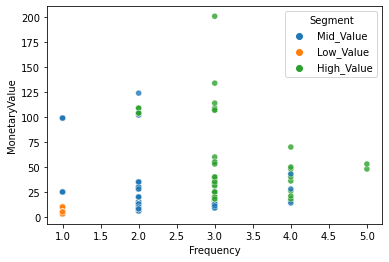

In [38]:
sns.scatterplot(
        x=summer_rfm['Frequency'],
        y=summer_rfm['MonetaryValue'],
        hue= summer_rfm['Segment'],    
        alpha=.8
        
)


<AxesSubplot:xlabel='Recency', ylabel='Frequency'>

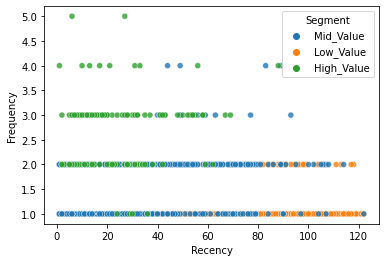

In [39]:
sns.scatterplot(
        x=summer_rfm['Recency'],
        y=summer_rfm['Frequency'],
        hue= summer_rfm['Segment'],   
        alpha=.8    )

<AxesSubplot:xlabel='MonetaryValue', ylabel='Recency'>

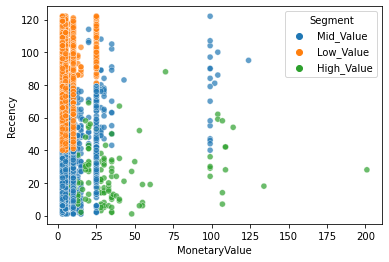

In [40]:
sns.scatterplot(
        x=summer_rfm['MonetaryValue'],
        y=summer_rfm['Recency'],
        hue= summer_rfm['Segment'] ,   
        alpha=.7    )

* High Value: Improve Retention
* Mid Value: Improve Retention + Increase Frequency
* Low Value: Increase Frequency

Let's take one last look at our summer_rfm table to make sure everything looks right

In [41]:
summer_rfm

,Recency,Frequency,MonetaryValue,CustomerID,RecencyCluster,FrequencyCluster,MonetaryValueCluster,OverallScore,Segment
0,11,2,7.98,4,3,2,1,6,Mid_Value
1,27,2,12.98,21,3,2,1,6,Mid_Value
2,32,2,12.98,116,3,2,1,6,Mid_Value
3,21,2,5.98,152,3,2,1,6,Mid_Value
4,15,2,5.98,217,3,2,1,6,Mid_Value
...,...,...,...,...,...,...,...,...,...
1706,55,1,99.00,1576,2,1,3,6,Mid_Value
1707,70,1,99.00,1891,2,1,3,6,Mid_Value
1708,58,1,99.00,3158,2,1,3,6,Mid_Value
1709,79,1,99.00,3193,2,1,3,6,Mid_Value


<a class="anchor" id="merge"></a>

### Merge RMF Data to Summer Users Dataframe

In [42]:
summer_users = summer_users.merge(summer_rfm, on='CustomerID', how='left')

In [43]:
summer_users['Segment'] = summer_users['Segment'].fillna('No_Value')

In [44]:
summer_users = summer_users.fillna(0)

In [45]:
summer_users

,CustomerID,CustomerType,Registrationdate,Sex,Age,fallbonus,Income,SummerSessionsCount,Experience,Pokestops,...,Distance,Duration,Recency,Frequency,MonetaryValue,RecencyCluster,FrequencyCluster,MonetaryValueCluster,OverallScore,Segment
0,1,1,2016-07-24,0,67,1,1,7,4198.285714,18.857143,...,8.127668,72.819201,0.0,0.0,0.00,0.0,0.0,0.0,0.0,No_Value
1,2,1,2016-10-07,0,14,1,2,8,4145.375000,18.750000,...,7.141789,56.491994,0.0,0.0,0.00,0.0,0.0,0.0,0.0,No_Value
2,3,1,2017-09-30,0,22,0,2,2,4123.000000,18.000000,...,3.728420,48.537186,0.0,0.0,0.00,0.0,0.0,0.0,0.0,No_Value
3,4,1,2018-04-06,0,8,0,3,5,4471.000000,16.600000,...,8.111869,65.811002,11.0,2.0,7.98,3.0,2.0,1.0,6.0,Mid_Value
4,5,4,2016-12-07,0,10,1,2,7,4429.285714,18.000000,...,1.364803,25.937571,0.0,0.0,0.00,0.0,0.0,0.0,0.0,No_Value
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4712,4996,3,2018-04-21,1,31,0,3,8,5290.875000,11.375000,...,1.471801,128.262914,32.0,2.0,5.98,3.0,2.0,1.0,6.0,Mid_Value
4713,4997,4,2016-08-22,1,30,1,2,6,4395.500000,18.333333,...,1.704352,22.036821,28.0,1.0,4.99,3.0,1.0,1.0,5.0,Mid_Value
4714,4998,3,2018-03-18,0,26,0,1,8,4959.125000,11.750000,...,1.779932,118.359626,76.0,2.0,7.98,2.0,2.0,1.0,5.0,Mid_Value
4715,4999,1,2018-04-02,0,20,0,3,2,4132.000000,18.500000,...,7.318011,85.912551,44.0,1.0,4.99,2.0,1.0,1.0,4.0,Low_Value


<a class="anchor" id="analyzerfm"></a>

## Analyzing RFM Demographics

In [46]:
#create horizontal line to show average churn rate
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

Text(0, 0.5, 'Count')

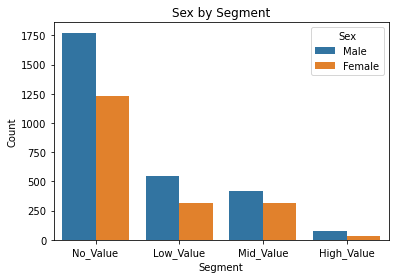

In [47]:
df_plot = summer_users.groupby(['Segment','Sex']).count()
df_plot.reset_index(level=0, inplace=True)
df_plot.reset_index(level=0, inplace=True)
df_plot.loc[df_plot.Sex== 0,'Sex'] = 'Male' 
df_plot.loc[df_plot.Sex==1,'Sex'] = 'Female'

ax = sns.barplot(x='Segment', y="CustomerID", hue="Sex", data=df_plot, order=['No_Value','Low_Value','Mid_Value','High_Value'])

ax.set_title("Sex by Segment")
ax.set_ylabel("Count")

Males seem to be more populous for each segment

Text(0, 0.5, 'Count')

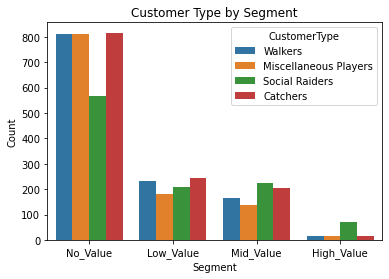

In [48]:
df_plot = summer_users.groupby(['Segment','CustomerType']).count().reset_index()
df_plot.loc[df_plot.CustomerType== 1,'CustomerType'] = 'Walkers' 
df_plot.loc[df_plot.CustomerType== 2,'CustomerType'] = 'Miscellaneous Players' 
df_plot.loc[df_plot.CustomerType== 3,'CustomerType'] = 'Social Raiders' 
df_plot.loc[df_plot.CustomerType== 4,'CustomerType'] = 'Catchers' 

ax = sns.barplot(x="Segment", y="CustomerID", data=df_plot, hue="CustomerType", order=['No_Value','Low_Value','Mid_Value','High_Value'])

ax.set_title("Customer Type by Segment")
ax.set_ylabel("Count")
#show_values_on_bars(ax)

It seems that our Social players tend to be the largest group in our high and mid value segments. They may be be a customer type worth investing in and marketing to.

Let's use boxplots to compare the spread and means of our numerical data seperated by segment.

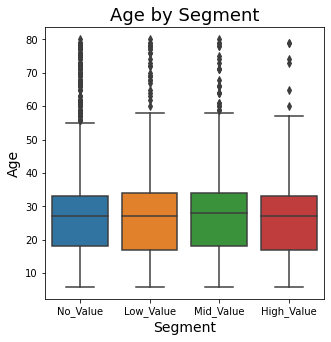

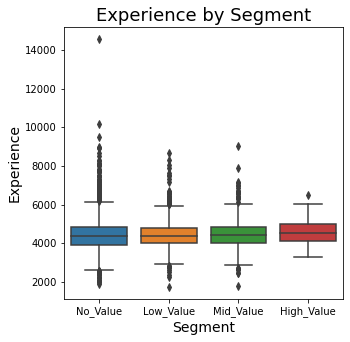

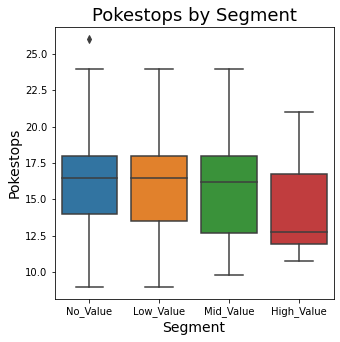

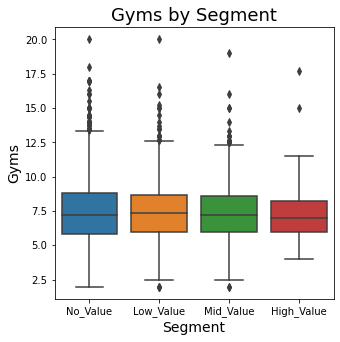

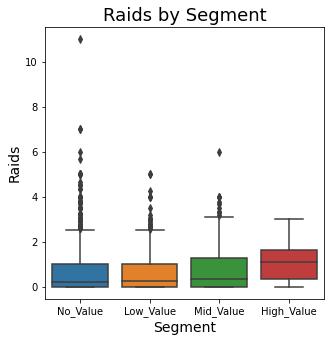

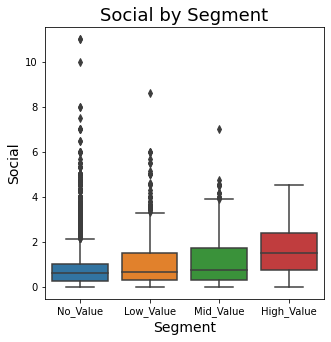

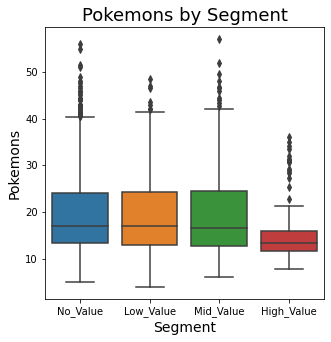

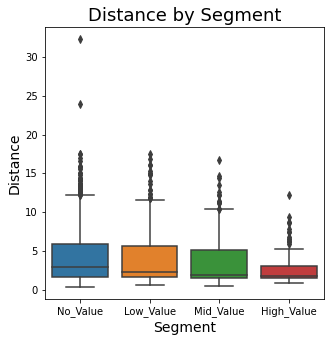

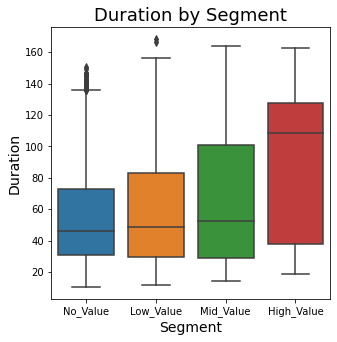

In [49]:
for feature in ['Age','Experience','Pokestops','Gyms','Raids','Social','Pokemons','Distance','Duration']:

    plt.figure(figsize=(5, 5))
    sns.boxplot(x="Segment", y= feature, 
            order=["No_Value","Low_Value","Mid_Value","High_Value"],
            data=summer_users)
    plt.ylabel(feature, size=14)
    plt.xlabel("Segment", size=14)
    plt.title(feature + " by Segment" , size=18)

Here we can see some trends in the data. It seems like the higher value customers seem to have higher duration, social, and raids and lower distance, pokemons, and pokestops.

<a class="anchor" id="calculatechurn"></a>

## Calculating Churn

Our first step here is to create a dataframe that has the indivual customers that played in the summer and whether or not they also played in the fall. Then we can calculate the churn rate as a percentage from summer to fall. We can then test to see if our fall bonus made a statistically significant difference in churn rate.

In [50]:
summersessions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20014 entries, 1 to 20014
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PlayID      20014 non-null  int64  
 1   Date        20014 non-null  object 
 2   CustomerID  20014 non-null  int64  
 3   Experience  20014 non-null  int64  
 4   Pokestops   20014 non-null  int64  
 5   Gyms        20014 non-null  int64  
 6   Raids       20014 non-null  int64  
 7   Social      20014 non-null  int64  
 8   Pokemons    20014 non-null  int64  
 9   Distance    20014 non-null  float64
 10  Duration    20014 non-null  float64
dtypes: float64(2), int64(8), object(1)
memory usage: 1.8+ MB


There are 20,014 rows in the summer sessions df from many of these sessions are the same player. Let's see how many unique players we had in the summer.

In [51]:
print('Number of Unique Summer Players:' , summersessions.CustomerID.nunique())

Number of Unique Summer Players: 4717


Let's make a list of these unque Customer ID's and create a df with a column called PlayedSummer filled with 1's to represent activeness in the summer.

In [52]:
#create a list of unique summer players
summerplayers_unique = summersessions['CustomerID'].unique().tolist()

In [53]:
#create df 
summerplayers = pd.DataFrame({ 'CustomerID': summerplayers_unique,
                       'PlayedSummer' : 1})

In [54]:
summerplayers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4717 entries, 0 to 4716
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   CustomerID    4717 non-null   int64
 1   PlayedSummer  4717 non-null   int64
dtypes: int64(2)
memory usage: 73.8 KB


We will do the same thing with our fall players by creating a fallplayers dataframe with 1's in the PlayedFall column to represent activeness in the Fall

In [55]:
print('Number of Unique Fall Players:' , fallsessions.CustomerID.nunique())

Number of Unique Fall Players: 3603


In [56]:
fallplayers_unique = fallsessions['CustomerID'].unique().tolist()

In [57]:
fallplayers = pd.DataFrame({ 'CustomerID': fallplayers_unique,
                       'PlayedFall' : 1})

In [58]:
fallplayers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3603 entries, 0 to 3602
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   CustomerID  3603 non-null   int64
 1   PlayedFall  3603 non-null   int64
dtypes: int64(2)
memory usage: 56.4 KB


Lastly we will left-join the fallplayers df onto the summerplayers df and call this df 'churn.'

In [59]:
churn = summerplayers.merge(fallplayers, on='CustomerID', how='left')

In [60]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4717 entries, 0 to 4716
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CustomerID    4717 non-null   int64  
 1   PlayedSummer  4717 non-null   int64  
 2   PlayedFall    3427 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 147.4 KB


In [61]:
#convert churn to integers
churn = churn.astype('Int64')

In [62]:
#calculate the missing values (this will tell us how many players left in the fall)
churn.isna().sum() 

CustomerID         0
PlayedSummer       0
PlayedFall      1290
dtype: int64

In [63]:
#calculate how many platers remained in the fall (did not churn)
churn.PlayedFall.count()

3427

We will now use our totals to calculate the churn percentage.

In [64]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4717 entries, 0 to 4716
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   CustomerID    4717 non-null   Int64
 1   PlayedSummer  4717 non-null   Int64
 2   PlayedFall    3427 non-null   Int64
dtypes: Int64(3)
memory usage: 161.2 KB


In [65]:
#calculate churn percentage
avg_churn = (1 - ( churn.PlayedFall.count() / churn.PlayedSummer.count() ))
avg_churn_percent = (1 - ( churn.PlayedFall.count() / churn.PlayedSummer.count() )) * 100
print('Churn Percentage:' , avg_churn_percent)



Churn Percentage: 27.347890608437563


Based off this, there were 3,427 summer players who continued to play in the fall, and 1,290 that churned making a 27.35% churn rate.

Next we want to replace the nans in the df (that represent the players that churned) with 0s.

In [66]:
churn['PlayedFall'] = churn['PlayedFall'].fillna(0)

Summary:
* Total Summer Players: 4717
* Total Fall Players: 3603
* Fall Players That Stayed From Summer: 3427
* Fall Players That Left After Summer: 1290
* New Fall Players: 176
* Total Unique Players: 4893

In [67]:
churn

,CustomerID,PlayedSummer,PlayedFall
0,4382,1,1
1,771,1,1
2,2495,1,1
3,3611,1,1
4,1708,1,1
...,...,...,...
4712,1080,1,1
4713,4252,1,0
4714,1163,1,1
4715,3633,1,0


Lastly we want to add the PlayedFall column to our summer_customers dataframe, title it 'churn,' and switch the labels so that 0 means No Churn and 1 means Churn.

In [68]:
summer_users = summer_users.merge(churn, on='CustomerID', how='left')

summer_users = summer_users.drop(columns='PlayedSummer')

summer_users = summer_users.rename(columns={"PlayedFall":"Churn"})

mapping = {0:1, 1:0}
summer_users['Churn'] = [mapping[i] for i in summer_users['Churn']]

summer_users['Churn'].value_counts()

0    3427
1    1290
Name: Churn, dtype: int64

<a class="anchor" id="analyzechurn"></a>

## Analyzing Churn Demographics

<a class="anchor" id="bysex"></a>

### By Sex

Lets start off with looking at the churn rates for male and female customers.

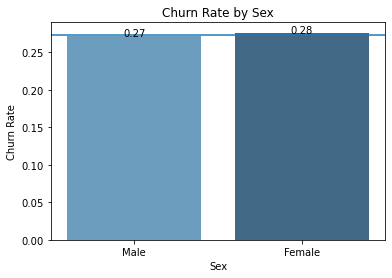

In [69]:
df_plot = summer_users.groupby('Sex').Churn.mean().reset_index()
df_plot.loc[df_plot.Sex== 0,'Sex'] = 'Male' 
df_plot.loc[df_plot.Sex==1,'Sex'] = 'Female'
ax = sns.barplot(x="Sex", y="Churn", data=df_plot, palette="Blues_d")
ax.axhline(avg_churn)

ax.set_title("Churn Rate by Sex")
ax.set_ylabel("Churn Rate")

show_values_on_bars(ax)

Both Male and Female seem to have a similar churn rate right at the average. Let's look at Customer Types.

<a class="anchor" id="bycustomertype"></a>

### By Customer Type

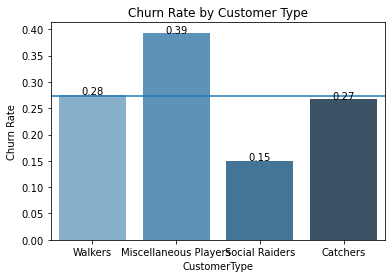

In [70]:
df_plot = summer_users.groupby('CustomerType').Churn.mean().reset_index()
df_plot.loc[df_plot.CustomerType== 1,'CustomerType'] = 'Walkers' 
df_plot.loc[df_plot.CustomerType== 2,'CustomerType'] = 'Miscellaneous Players' 
df_plot.loc[df_plot.CustomerType== 3,'CustomerType'] = 'Social Raiders' 
df_plot.loc[df_plot.CustomerType== 4,'CustomerType'] = 'Catchers' 

ax = sns.barplot(x="CustomerType", y="Churn", data=df_plot, palette="Blues_d")
ax.axhline(avg_churn)
ax.set_title("Churn Rate by Customer Type")
ax.set_ylabel("Churn Rate")


show_values_on_bars(ax)

While Walkers and Catchers seem to churn at the average, Miscellaneous Players have the highest churn rate of 39% and Social Raiders have the lowest of around 15%. 

<a class="anchor" id="byage"></a>

### By Age Group

In [71]:
df_plot = summer_users

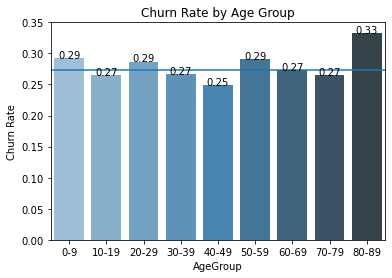

In [72]:
bins= [0,10,20,30,40,50,60,70,80,90]
labels = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89']
summer_users['AgeGroup'] = pd.cut(summer_users['Age'], bins=bins, labels=labels, right=False)

df_plot = summer_users.groupby('AgeGroup').Churn.mean().reset_index()

ax = sns.barplot(x="AgeGroup", y="Churn", data=df_plot, palette="Blues_d")
ax.axhline(avg_churn)
ax.set_title("Churn Rate by Age Group")
ax.set_ylabel("Churn Rate")

show_values_on_bars(ax)

It seems like our oldest users have the highest churn rate, our 40-49 bracket having the lowest, and all others hovering pretty close to average.

<a class="anchor" id="byincome"></a>

### By Income

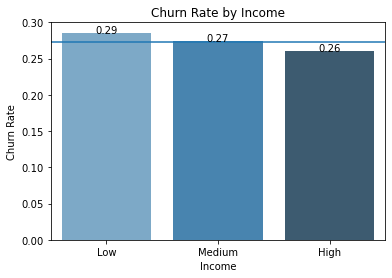

In [73]:
df_plot = summer_users.groupby('Income').Churn.mean().reset_index()
df_plot.loc[df_plot.Income== 1,'Income'] = 'Low' 
df_plot.loc[df_plot.Income==2,'Income'] = 'Medium'
df_plot.loc[df_plot.Income==3,'Income'] = 'High'

ax = sns.barplot(x="Income", y="Churn", data=df_plot, palette="Blues_d")
ax.axhline(avg_churn)
ax.set_title("Churn Rate by Income")
ax.set_ylabel("Churn Rate")

show_values_on_bars(ax)

<a class="anchor" id="bysegment"></a>

### By Segment

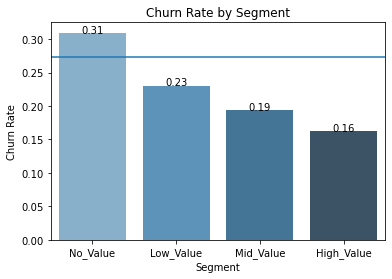

In [74]:
df_plot = summer_users.groupby('Segment').Churn.mean().reset_index()
ax = sns.barplot(x="Segment", y="Churn", data=df_plot, palette="Blues_d", order=['No_Value','Low_Value','Mid_Value','High_Value'])
ax.axhline(avg_churn)
ax.set_title("Churn Rate by Segment")
ax.set_ylabel("Churn Rate")

show_values_on_bars(ax)

It's pretty apparent that the higher value customers tend to have a lower churn rate, which is good for revenue. It seems that if we can get the user to make at least one purchase, they are much less likely to churn.

<AxesSubplot:xlabel='OverallScore', ylabel='Churn'>

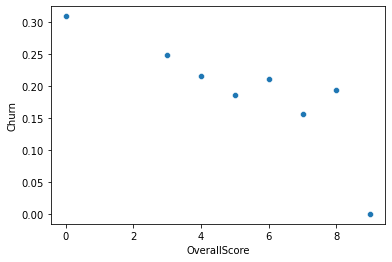

In [75]:
df_plot = summer_users.groupby('OverallScore').Churn.mean().reset_index()
sns.scatterplot(x='OverallScore',y='Churn', data=df_plot)

As expected, the higher overall score when it comes to our RFM segments, the lower the churn rate.

<a class="anchor" id="byfeatures"></a>

### By In-Game Features

Lastly, lets look at churn compared to our in-game features

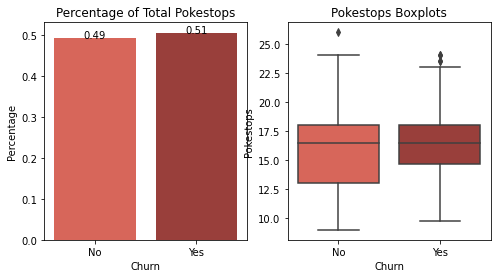

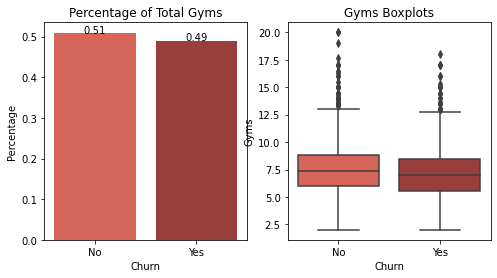

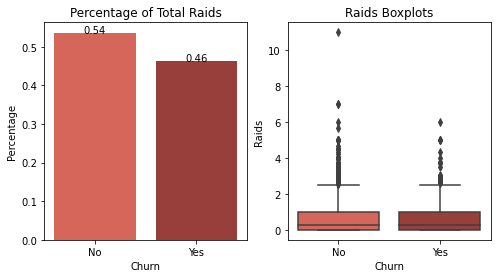

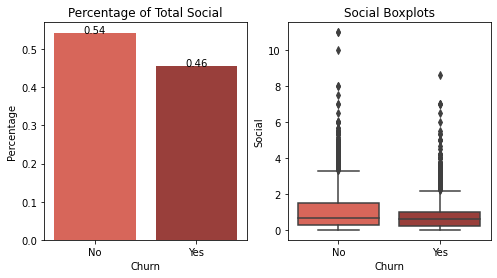

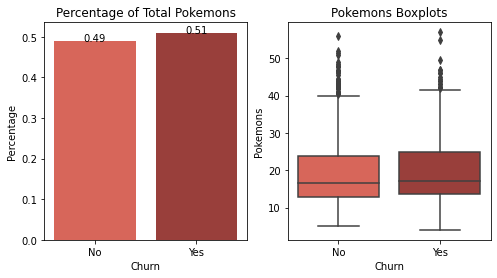

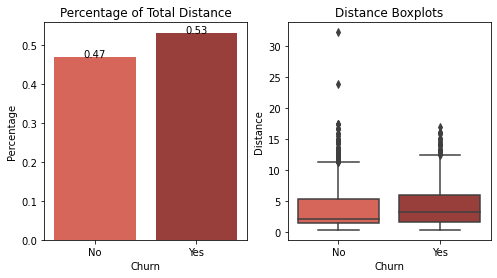

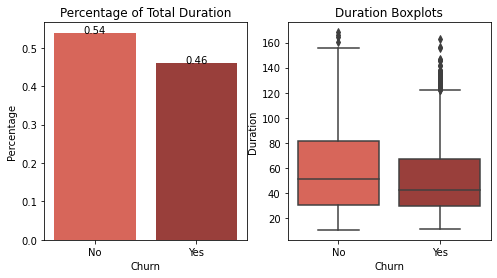

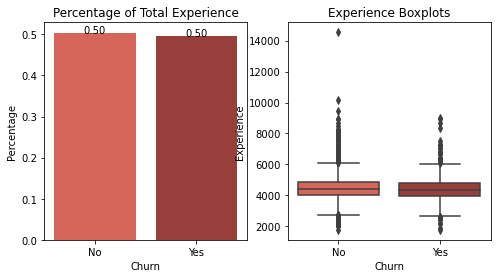

In [76]:
metrics = ['Pokestops' , 'Gyms', 'Raids','Social','Pokemons','Distance','Duration','Experience']
for metric in metrics:
    fig, axs = plt.subplots(ncols=2 , figsize=(8, 4))
    df_plot = summer_users.groupby('Churn')[metric].mean().reset_index()
    df_plot['Normalized'] = (df_plot[[metric]] / (df_plot[[metric]].sum()))
    df_plot.loc[df_plot.Churn== 0,'Churn'] = 'No' 
    df_plot.loc[df_plot.Churn==1,'Churn'] = 'Yes'
    
    df_plot2 = summer_users
    df_plot2.loc[df_plot2.Churn== 0,'Churn'] = 'No' 
    df_plot2.loc[df_plot2.Churn==1,'Churn'] = 'Yes'
    
    ax1 = sns.barplot(x="Churn", y='Normalized', data=df_plot, palette="Reds_d", ax=axs[0])
    ax1.set(xlabel='Churn', ylabel='Percentage', title= 'Percentage of Total '+ metric)
    
    ax2 = sns.boxplot(x="Churn", y= metric, 
            order=['No','Yes'],
            data=df_plot2, ax=axs[1], palette="Reds_d")
    #plt.ylabel(feature, size=14)
    #plt.xlabel("Segment", size=14)
    plt.title(metric + ' Boxplots' )
    
    
    
    show_values_on_bars(ax1)
    


It seems that the more social actions and raids a play does, lessens their churn percentage. It could be that incentivizing the social aspects of the game could be a good marketing tool.

<a class="anchor" id="fallpromo"></a>

## Evaluating Effectiveness of Fall Bonus

The goal here is to determine if the Fall Promo, which was only sent to some of the customers had an effect on churn rate. First lets get a glace at the churn percentages of the customers who received the promo vs didn't receive the promo.

In [77]:
summer_users.loc[summer_users.Churn== 'Yes','Churn'] = 1 
summer_users.loc[summer_users.Churn== 'No','Churn'] = 0
summer_users['Churn'] = summer_users['Churn'].astype(int)

In [78]:
summer_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4717 entries, 0 to 4716
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   CustomerID            4717 non-null   int64   
 1   CustomerType          4717 non-null   int64   
 2   Registrationdate      4717 non-null   object  
 3   Sex                   4717 non-null   int64   
 4   Age                   4717 non-null   int64   
 5   fallbonus             4717 non-null   int64   
 6   Income                4717 non-null   int64   
 7   SummerSessionsCount   4717 non-null   int64   
 8   Experience            4717 non-null   float64 
 9   Pokestops             4717 non-null   float64 
 10  Gyms                  4717 non-null   float64 
 11  Raids                 4717 non-null   float64 
 12  Social                4717 non-null   float64 
 13  Pokemons              4717 non-null   float64 
 14  Distance              4717 non-null   float64 
 15  Dura

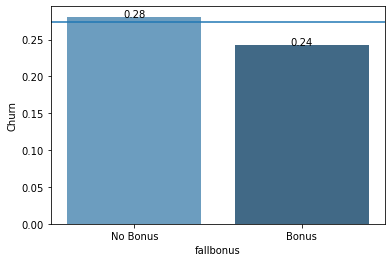

In [79]:
df_plot = summer_users.groupby('fallbonus').Churn.mean().reset_index()
df_plot.loc[df_plot.fallbonus== 0,'fallbonus'] = 'No Bonus' 
df_plot.loc[df_plot.fallbonus==1,'fallbonus'] = 'Bonus'

ax = sns.barplot(x="fallbonus", y="Churn", data=df_plot, palette="Blues_d")
ax.axhline(avg_churn)

show_values_on_bars(ax)

The users who recieved the promo had a lower churn rate than those who did not. Let's create a hypothesis test and test to see if these variales are independent.

<a class="anchor" id="hypothesis"></a>

### Hypothesis Test

Our null hypthesis is that the two variables, Churn and fallbonus are independent. In other words, the fall bonus had no statistically significant effect on whether or not a user churned. Because we have two categorical variables, we will conduct a chi-squared test with a significance level (alpha) of .05. First, we must make a contingency table with the relevant data.

In [80]:
contingencytable = summer_users.groupby(['fallbonus','Churn']).count().reset_index()
contingencytable.loc[contingencytable.fallbonus== 0,'fallbonus'] = 'No Bonus' 
contingencytable.loc[contingencytable.fallbonus==1,'fallbonus'] = 'Bonus'
contingencytable.loc[contingencytable.Churn== 0,'Churn'] = 'No' 
contingencytable.loc[contingencytable.Churn==1,'Churn'] = 'Yes'
contingencytable = contingencytable.pivot(index='fallbonus', columns='Churn', values='CustomerID')
contingencytable

Churn,No,Yes
fallbonus,,
Bonus,716,230
No Bonus,2711,1060


Next we will run the chi-squraed test and print the results.

In [81]:
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2
# contingency table
table = contingencytable
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')


Churn        No   Yes
fallbonus            
Bonus       716   230
No Bonus   2711  1060
dof=1
[[ 687.28895484  258.71104516]
 [2739.71104516 1031.28895484]]
probability=0.950, critical=3.841, stat=5.296
Dependent (reject H0)
significance=0.050, p=0.021
Dependent (reject H0)


Both our critical value (stat) and our p-value (p) suggest that we can reject the null hypothesis and conclude that there is a statistical significance between the churn rates of users who received the bonus and did not. In other words, the bonus was effective in reducing churn.

<a class="anchor" id="churn"></a>

## Predicting Churn Rate

<a class="anchor" id="featureengineering"></a>

### Feature Engineering

Before we do anything, let's look at the heatmap of our features to see if there are any strong correlations (specifically with churn rate).

<AxesSubplot:>

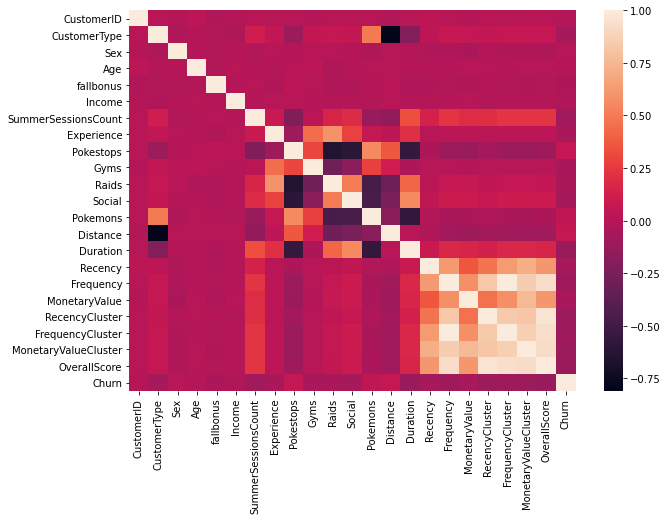

In [82]:
plt.figure(figsize = (10,7))
sns.heatmap(summer_users.corr())

We will create a dataframe that is engineered and ready for modeling called summer_features.

First, we need to replace Registrationdate with the total number of days the customer has been a user of the app in a column called DasAsUser.

In [83]:
summer_users['Registrationdate']= pd.to_datetime(summer_users['Registrationdate'])

In [84]:
summer_features = summer_users

In [85]:
#create DaysAsUser DataFrame
DaysAsUser = summer_features.groupby(['CustomerID']).agg({
    'Registrationdate' : lambda x: (snapshot_date - x.max()).days}).reset_index()

DaysAsUser.rename(columns = {'Registrationdate': 'DaysAsUser'}, inplace=True)

In [86]:
#merge DaysAsUser onto summer_features dataframe
summer_features = summer_features.merge(DaysAsUser, on='CustomerID', how='left')

In [87]:
#drop registration date column
#summer_features_modeling = summer_features.drop(columns='Registrationdate')

Lastly, we will drop the appropriate columns to create a table used for modeling.

In [88]:
summer_features_modeling = summer_features.drop(columns = ['Registrationdate','AgeGroup','CustomerID','fallbonus','Recency','Frequency','MonetaryValue','RecencyCluster','FrequencyCluster','MonetaryValueCluster','OverallScore','Segment'])
#summer_features = summer_features.drop(columns = ['AgeGroup','CustomerID','CustomerType','fallbonus','Sex','Age','SummerSessionsCount','Experience','Pokestops','Gyms','Raids','Social','Pokemons','Recency','Frequency','MonetaryValue','RecencyCluster','FrequencyCluster','MonetaryValueCluster','Segment_High_Value','Segment_Low_Value','Segment_Mid_Value'])




In [89]:
summer_features_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4717 entries, 0 to 4716
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerType         4717 non-null   int64  
 1   Sex                  4717 non-null   int64  
 2   Age                  4717 non-null   int64  
 3   Income               4717 non-null   int64  
 4   SummerSessionsCount  4717 non-null   int64  
 5   Experience           4717 non-null   float64
 6   Pokestops            4717 non-null   float64
 7   Gyms                 4717 non-null   float64
 8   Raids                4717 non-null   float64
 9   Social               4717 non-null   float64
 10  Pokemons             4717 non-null   float64
 11  Distance             4717 non-null   float64
 12  Duration             4717 non-null   float64
 13  Churn                4717 non-null   int64  
 14  DaysAsUser           4717 non-null   int64  
dtypes: float64(8), int64(7)
memory usage: 

Now our dataframe has no null values, consists solely of numerical features, and is ready for modeling

<a class="anchor" id="metrics"></a>

### Designating Metrics and Choosing Models

Our goal is to be able to predict which customers will churn based on their demographic and user data. So our target variable within our dataframe is "Churn." Because the classess are either 0 or 1 (no churn or churn, respectively), this is a binary classification problem. Let's remind ourselves of the number of samples we have of each class.

In [90]:
#calculate sample size percentages
round( summer_features_modeling['Churn'].value_counts(normalize=True) * 100 , 2)

0    72.65
1    27.35
Name: Churn, dtype: float64

Because our sample is uneven with over 72% of the users not churning, we will need to consider this an imbalanced dataset.

#### Metrics

Let's go over the metrics we will use to assess our models:
* F1 score with emphasis on recall(true positive rate) - we want to prioritize finding the maximum percentage of people who will churn so we can find solutions to keep them around.

* Precision-Recall curve and PR AUC (average precision)- because we care more about the positive class (churn), this metric will be better than the ROC Curve.

* Accuracy

#### Models

We will test the following models

* Logistic Regression
* Random Forest
* GradientBoost
* K-Nearest-Neighbors
* CatBoost

<a class="anchor" id="functions"></a>

### Defining Useful Functions

In [91]:
#printing classification report, confusion matrix, and precision-recall curve
def evaluation_block(model):
    #global train_acc, test_acc
    
    y_tr_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    train_avgprecision = round(average_precision_score(y_train, y_tr_pred),4)
    test_avgprecision = round(average_precision_score(y_test, y_pred),4)
    train_acc = round(accuracy_score(y_train,y_tr_pred),4)
    test_acc = round(accuracy_score(y_test,y_pred),4)
    train_f1 = round(f1_score(y_train, y_tr_pred, average='weighted'),4)
    test_f1 = round(f1_score(y_test, y_pred, average='weighted'),4)
    train_logloss = round(log_loss(y_train,y_tr_pred),4)
    test_logloss = round(log_loss(y_test,y_pred),4)
    
    print("Train - F1:", train_f1)
    print("Test - F1:", test_f1)
    print("Train - Avg Precision:", train_avgprecision)
    print("Test - Avg Precision:", test_avgprecision)
    print("Train - Accuracy:", train_acc)
    print("Test - Accuracy:", test_acc)


    print('Validation - Classification report\n', classification_report(y_test,y_pred))
    plt.figure(figsize=(9,9))
    plot_confusion_matrix(model, X_test, y_test, normalize='true', cmap = 'Blues')
    plt.show()
    
    print('Precision-Recall Curve\n')
    # no skill model, stratified random class predictions
    dummymodel = DummyClassifier(strategy='stratified', random_state=10)
    dummymodel.fit(X_train, y_train)
    yhat = dummymodel.predict_proba(X_test)
    pos_probsdummy = yhat[:, 1]
    # calculate the precision-recall auc
    precision, recall, _ = precision_recall_curve(y_test, pos_probsdummy)
    auc_scoredummy = auc(recall, precision)
    print('No Skill PR AUC: %.3f' % auc_scoredummy)
    
    # fit a model
    modelm = model
    modelm.fit(X_train, y_train)
    yhat = modelm.predict_proba(X_test)
    pos_probsm = yhat[:, 1]
    # calculate the precision-recall auc
    precision, recall, _ = precision_recall_curve(y_test, pos_probsm)
    auc_scorem = auc(recall, precision)
    print(model, 'PR AUC: %.3f' % auc_scorem)
    
    # predict probabilities
    yhat = model.predict_proba(X_test)
    # retrieve just the probabilities for the positive class
    pos_probs = yhat[:, 1]
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(y[y==1]) / len(y)
    # plot the no skill precision-recall curve
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # calculate model precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, pos_probs)
    # plot the model precision-recall curve
    plt.plot(recall, precision, marker='.', label=model)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [92]:
#create function to perform random search on a given model and parameter grid
def rand_cv(model, param_grid, name):
    # Random search of parameters, using 3 fold cross validation, 
    random = RandomizedSearchCV(estimator = model, param_distributions = param_grid , scoring= 'f1_weighted', n_iter=100, cv = 3, verbose=10, random_state=10, n_jobs = -1)
    random.fit(X_train, y_train)
    print('Best Parameters based on Randomized Search CV:', random.best_params_)
    print('Best score: ', random.best_score_)
    evaluation_block(random)
    save_scores(random, name)

In [93]:
#create a dataframe to store and compare our model results
results = pd.DataFrame(columns = ['model','name','train_accuracy', 'test_accuracy', 'train_f1', 'test_f1','train_avgprecision','test_avgprecision','PR AUC'])
pd.set_option("max_colwidth", 100)
def save_scores(model, name):
    y_tr_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    train_avgprecision = round(average_precision_score(y_train, y_tr_pred),4)
    test_avgprecision = round(average_precision_score(y_test, y_pred),4)
    train_acc = round(accuracy_score(y_train,y_tr_pred),4)
    test_acc = round(accuracy_score(y_test,y_pred),4)
    train_f1 = round(f1_score(y_train, y_tr_pred, average='weighted'),4)
    test_f1 = round(f1_score(y_test, y_pred, average='weighted'),4)
    
    yhat = model.predict_proba(X_test)
    pos_probsm = yhat[:, 1]
    # calculate the precision-recall auc
    precision, recall, _ = precision_recall_curve(y_test, pos_probsm)
    auc_scorem = auc(recall, precision)
    #print(model, 'PR AUC: %.3f' % auc_scorem)
    
    new_row = {'model':model,
               'name': name,
               'train_accuracy': train_acc,
               'test_accuracy': test_acc,
               'train_f1': train_f1,
               'test_f1': test_f1,
               'train_avgprecision' : train_avgprecision,
               'test_avgprecision': test_avgprecision,
               'PR AUC': auc_scorem
              }
    results.loc[0 if pd.isnull(results.index.max()) else results.index.max() + 1] = new_row

<a class="anchor" id="pre"></a>

### Data Pre-processing

Create our X (features) and y(target variable)

In [94]:
X = summer_features_modeling.drop('Churn', axis=1)
        
y = summer_features_modeling['Churn']
X.shape, y.shape

((4717, 14), (4717,))

Because our data is highly imbalanced, we will oversample our minority (users who churned) to create a balanced dataset.

In [95]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')

In [96]:
X_over, y_over = oversample.fit_resample(X, y)

Now we will split our data in train and test.

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.25, random_state=40)

Finally we will apply sklearn's StandardScaler.

In [98]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

<a class="anchor" id="logimportant"></a>

### Using Logistic Regression to find important features

Along with being a robust model, Logistic Regression provides interpretable outcomes too. Before running our model, lets use Generalized Linear Model to see the important features regarding Churn.

In [99]:
X_columns = ''

for column in summer_features_modeling.columns:
    if column not in ['Churn','CustomerID']:
        X_columns = X_columns + ' + ' + column

In [100]:
summer_model = smf.glm(formula='Churn ~ {}'.format(X_columns), data=summer_features_modeling, family=sm.families.Binomial())
res = summer_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Churn   No. Observations:                 4717
Model:                            GLM   Df Residuals:                     4702
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2682.6
Date:                Tue, 07 Sep 2021   Deviance:                       5365.3
Time:                        11:58:52   Pearson chi2:                 4.73e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.1395    

We have two important outcomes from this report. When you prepare a Churn Prediction model, you will face with the questions below:

1. Which characteristics make customers churn or retain?
2. What are the most critical ones? What should we focus on?

For the first question, you should look at the 4th column (P>|z|). If the absolute p-value is smaller than 0.05, it means, that feature affects Churn in a statistically significant way. Examples are:

   * Customer Type
   * Fall Bonus
   * Duration
   * Days as user

Customer Type and Fallbonus alignes with our previous analysis and it makes sense that the more you like the game, the more often you play it and are less likely to churn.

<a class="anchor" id="ootb"></a>

## Out Of The Box (OOTB) Models

<a class="anchor" id="logreg"></a>

### Logistic Regression OOTB Model

In [101]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
y_pred = logisticRegr.predict(X_test)

Train - F1: 0.592
Test - F1: 0.5673
Train - Avg Precision: 0.5504
Test - Avg Precision: 0.5498
Train - Accuracy: 0.5924
Test - Accuracy: 0.5683
Validation - Classification report
               precision    recall  f1-score   support

           0       0.56      0.52      0.54       836
           1       0.57      0.62      0.59       878

    accuracy                           0.57      1714
   macro avg       0.57      0.57      0.57      1714
weighted avg       0.57      0.57      0.57      1714



<Figure size 648x648 with 0 Axes>

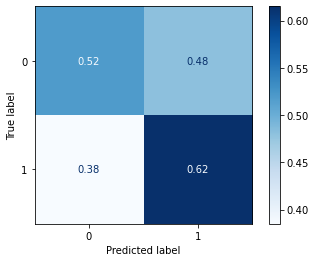

Precision-Recall Curve

No Skill PR AUC: 0.648
LogisticRegression() PR AUC: 0.585


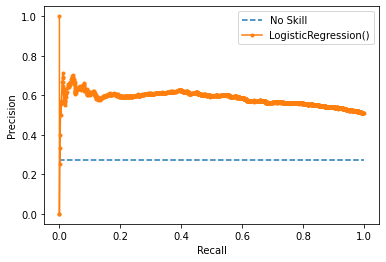

In [102]:
evaluation_block(logisticRegr)

In [103]:
save_scores(logisticRegr, 'LogisticReg OOTB')

<a class="anchor" id="randomforest"></a>

### RandomForest OOTB Model

In [104]:
rfc = RandomForestClassifier(random_state=10)
rfc.fit(X_train, y_train)
#y_pred = rfc.predict(X_test)

RandomForestClassifier(random_state=10)

Train - F1: 1.0
Test - F1: 0.8522
Train - Avg Precision: 1.0
Test - Avg Precision: 0.801
Train - Accuracy: 1.0
Test - Accuracy: 0.8524
Validation - Classification report
               precision    recall  f1-score   support

           0       0.86      0.83      0.85       836
           1       0.84      0.88      0.86       878

    accuracy                           0.85      1714
   macro avg       0.85      0.85      0.85      1714
weighted avg       0.85      0.85      0.85      1714



<Figure size 648x648 with 0 Axes>

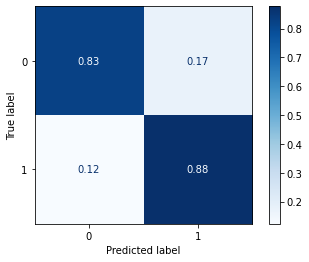

Precision-Recall Curve

No Skill PR AUC: 0.648
RandomForestClassifier(random_state=10) PR AUC: 0.957


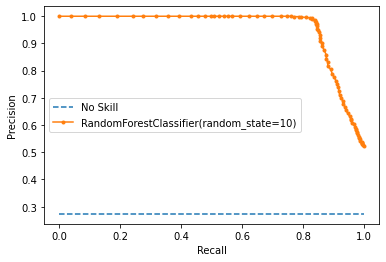

In [105]:
evaluation_block(rfc)

In [106]:
save_scores(rfc, 'RandomForest OOTB')

In [107]:
results

,model,name,train_accuracy,test_accuracy,train_f1,test_f1,train_avgprecision,test_avgprecision,PR AUC
0,LogisticRegression(),LogisticReg OOTB,0.5924,0.5683,0.592,0.5673,0.5504,0.5498,0.584761
1,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",RandomForest OOTB,1.0000,0.8524,1.000,0.8522,1.0000,0.8010,0.956510


<a class="anchor" id="gradientboost"></a>

### GradientBoosting OOTB Model

In [108]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)
y_pred = gbc.predict(X_test)

Train - F1: 0.7118
Test - F1: 0.6326
Train - Avg Precision: 0.6461
Test - Avg Precision: 0.5943
Train - Accuracy: 0.7119
Test - Accuracy: 0.633
Validation - Classification report
               precision    recall  f1-score   support

           0       0.63      0.60      0.61       836
           1       0.64      0.66      0.65       878

    accuracy                           0.63      1714
   macro avg       0.63      0.63      0.63      1714
weighted avg       0.63      0.63      0.63      1714



<Figure size 648x648 with 0 Axes>

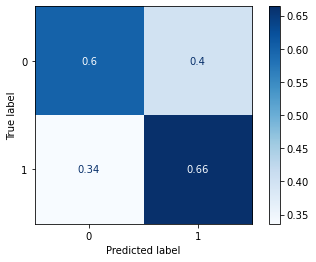

Precision-Recall Curve

No Skill PR AUC: 0.648
GradientBoostingClassifier() PR AUC: 0.665


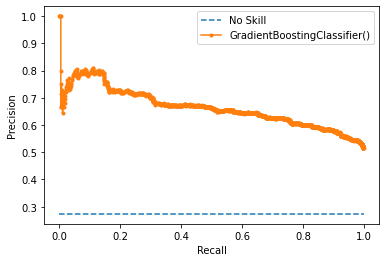

In [109]:
evaluation_block(gbc)

In [110]:
save_scores(gbc, 'GradientBoost OOTB')

<a class="anchor" id="catboost"></a>

### CatBoost OOTB Model

In [111]:
cat = CatBoostClassifier(eval_metric = 'F1', verbose=False)
cat.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

In [112]:
print(cat.get_best_score())

{'learn': {'Logloss': 0.22472664098784756, 'F1': 0.9852912335752109}, 'validation': {'Logloss': 0.4655155861463693, 'F1': 0.8086021505376344}}


In [113]:
y_pred = cat.predict(X_test)
y_tr_pred = cat.predict(X_train)

Train - F1: 0.9854
Test - F1: 0.7912
Train - Avg Precision: 0.9782
Test - Avg Precision: 0.7294
Train - Accuracy: 0.9854
Test - Accuracy: 0.7923
Validation - Classification report
               precision    recall  f1-score   support

           0       0.83      0.72      0.77       836
           1       0.77      0.86      0.81       878

    accuracy                           0.79      1714
   macro avg       0.80      0.79      0.79      1714
weighted avg       0.80      0.79      0.79      1714



<Figure size 648x648 with 0 Axes>

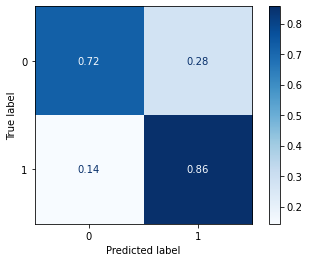

Precision-Recall Curve

No Skill PR AUC: 0.648
<catboost.core.CatBoostClassifier object at 0x7fdce86245e0> PR AUC: 0.832


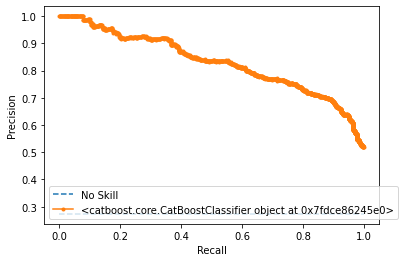

In [114]:
evaluation_block(cat)

In [115]:
save_scores(cat, 'CatBoost OOTB')

<a class="anchor" id="knn"></a>

### KNN Model

The last model we will test is the K-Nearest-Neighbors model. We will create a for loop to test multiple models all having different n_neighbor parameters and compare the results.

In [116]:
import time
from time import process_time


---------------Test scores : KNeighborsClassifier model with 2 neighbors--------------
Test - F1:  0.7001
Test - Average Precision Score: 0.6617 

1.3713789999999975 seconds
---------------Test scores : KNeighborsClassifier model with 3 neighbors--------------
Test - F1:  0.7142
Test - Average Precision Score: 0.6259 

1.757323999999997 seconds
---------------Test scores : KNeighborsClassifier model with 5 neighbors--------------
Test - F1:  0.6638
Test - Average Precision Score: 0.5948 

2.086921000000004 seconds
---------------Test scores : KNeighborsClassifier model with 7 neighbors--------------
Test - F1:  0.6367
Test - Average Precision Score: 0.5793 

2.311717999999999 seconds
---------------Test scores : KNeighborsClassifier model with 9 neighbors--------------
Test - F1:  0.6367
Test - Average Precision Score: 0.576 

2.390488000000005 seconds
---------------Test scores : KNeighborsClassifier model with 11 neighbors--------------
Test - F1:  0.6327
Test - Average Precision Sco

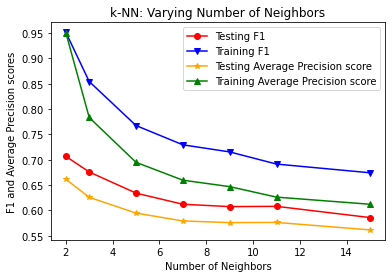

In [117]:
no_neighbors = (2,3,5,7,9,11,15)
train_ap = np.empty(len(no_neighbors))
test_ap = np.empty(len(no_neighbors))
train_ff1 = np.empty(len(no_neighbors))
test_ff1 = np.empty(len(no_neighbors))

for i, k in enumerate(no_neighbors):
    start = time.process_time()  
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    
    y_pred = knn.predict(X_test)
    y_pred_prob = knn.predict_proba(X_test)[:,1]
    
    y_tr_pred = knn.predict(X_train)
    y_tr_pred_prob = knn.predict_proba(X_train)[:,1]
    

    train_avgprecision = round(average_precision_score(y_train, y_tr_pred),4)
    test_avgprecision = round(average_precision_score(y_test, y_pred),4)
    train_acc = round(accuracy_score(y_train,y_tr_pred),4)
    test_acc = round(accuracy_score(y_test,y_pred),4)
    train_f1 = round(f1_score(y_train, y_tr_pred, average='weighted'),4)
    test_f1 = round(f1_score(y_test, y_pred, average='weighted'),4)
    
    yhat = knn.predict_proba(X_test)
    pos_probsm = yhat[:, 1]
    # calculate the precision-recall auc
    precision, recall, _ = precision_recall_curve(y_test, pos_probsm)
    auc_scorem = auc(recall, precision)
    
    train_ap[i] = train_avgprecision
    test_ap[i] = test_avgprecision
    train_ff1[i] = train_f1
    test_ff1[i] = test_f1
    
    save_scores(knn, 'KNN with {} neighbors'.format(k))
    
    print('---------------Test scores : KNeighborsClassifier model with {} neighbors--------------'.format(k))
    print('Test - F1: ', round(f1_score(y_test,y_pred),4))    
    print('Test - Average Precision Score: {} \n'.format(round(average_precision_score(y_test, y_pred),4)))
    
    print(time.process_time() - start, 'seconds')

plt.title('k-NN: Varying Number of Neighbors')
plt.plot(no_neighbors, test_ff1, label = 'Testing F1', marker = 'o', c = 'red')
plt.plot(no_neighbors, train_ff1, label = 'Training F1', marker = 'v', c = 'blue')
plt.plot(no_neighbors, test_ap, label = 'Testing Average Precision score', marker = '*', c = 'orange')
plt.plot(no_neighbors, train_ap, label = 'Training Average Precision score', marker = '^', c = 'green')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('F1 and Average Precision scores')
plt.show()

In [118]:
results.sort_values('PR AUC', ascending = False).head(25)

,model,name,train_accuracy,test_accuracy,train_f1,test_f1,train_avgprecision,test_avgprecision,PR AUC
1,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",RandomForest OOTB,1.0000,0.8524,1.0000,0.8522,1.0000,0.8010,0.956510
3,<catboost.core.CatBoostClassifier object at 0x7fdce86245e0>,CatBoost OOTB,0.9125,0.7468,0.9124,0.7460,0.8697,0.6876,0.831797
4,KNeighborsClassifier(n_neighbors=2),KNN with 2 neighbors,0.9518,0.7071,0.9516,0.7068,0.9510,0.6617,0.802276
5,KNeighborsClassifier(n_neighbors=3),KNN with 3 neighbors,0.8554,0.6797,0.8544,0.6759,0.7834,0.6259,0.757131
6,KNeighborsClassifier(),KNN with 5 neighbors,0.7685,0.6359,0.7675,0.6342,0.6949,0.5948,0.684399
2,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n random_sta...",GradientBoost OOTB,0.7119,0.6330,0.7118,0.6326,0.6461,0.5943,0.665188
7,KNeighborsClassifier(n_neighbors=7),KNN with 7 neighbors,0.7304,0.6132,0.7295,0.6122,0.6597,0.5793,0.660491
8,KNeighborsClassifier(n_neighbors=9),KNN with 9 neighbors,0.7163,0.6091,0.7155,0.6076,0.6470,0.5760,0.638788
9,KNeighborsClassifier(n_neighbors=11),KNN with 11 neighbors,0.6922,0.6091,0.6915,0.6081,0.6263,0.5764,0.619549
10,KNeighborsClassifier(n_neighbors=15),KNN with 15 neighbors,0.6747,0.5869,0.6743,0.5859,0.6122,0.5616,0.602381


Based of the results and as seen by the graph, the best model was the one with 2 neighbors. After this our model only goes down in performance. Regardless, all KNN models didn't do as well as the RandomForest or CatBoost Models.

<a class="anchor" id="hyperparameter"></a>

### Hyperparameter Tuning and Feature Selection for our best OOTB Models

To hyperparameter tune our best two Models (Random Forest and Catboost), we will perform a Randomized Grid search using our previously defined rand_cv model. We will then test for the best threshold of important features on both models.

<a class="anchor" id="randomtuned"></a>

#### Random Forest Tuned Model

In [119]:
param_grid = {   'bootstrap': [True, False],
                 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
                 'max_features': ['auto', 'sqrt'],
                 'min_samples_leaf': [1, 2, 4],
                 'min_samples_split': [2, 5, 10],
                 'n_estimators': [10, 50, 75, 100,1000, 1500, 2000]
             }

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters based on Randomized Search CV: {'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}
Best score:  0.8018694205387825
Train - F1: 1.0
Test - F1: 0.8821
Train - Avg Precision: 1.0
Test - Avg Precision: 0.851
Train - Accuracy: 1.0
Test - Accuracy: 0.8821
Validation - Classification report
               precision    recall  f1-score   support

           0       0.86      0.91      0.88       836
           1       0.91      0.86      0.88       878

    accuracy                           0.88      1714
   macro avg       0.88      0.88      0.88      1714
weighted avg       0.88      0.88      0.88      1714



<Figure size 648x648 with 0 Axes>

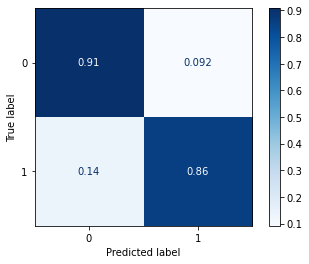

Precision-Recall Curve

No Skill PR AUC: 0.648
Fitting 3 folds for each of 100 candidates, totalling 300 fits
RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=10),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 75, 100, 1000,
                                                         1500, 2000]},
                   random_state=10, scoring='f1_weighted', verbose=10) PR AUC: 0.957


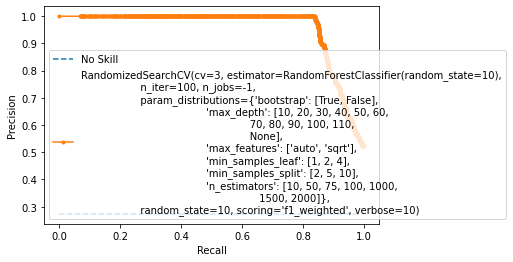

In [120]:
rand_cv(rfc, param_grid, 'Random Forest Tuned')

Let's see how our tuned model compares.

In [125]:
rfc_tuned = RandomForestClassifier(n_estimators= 2000, min_samples_split= 5, min_samples_leaf= 1, max_features= 'auto', max_depth= 80, bootstrap= False,random_state=10)
rfc_tuned.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_split=5,
                       n_estimators=2000, random_state=10)

In [126]:
results.sort_values('test_f1', ascending = False).head(25)

,model,name,train_accuracy,test_accuracy,train_f1,test_f1,train_avgprecision,test_avgprecision,PR AUC
11,"RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=10),\n ...",Random Forest Tuned,1.0000,0.8821,1.0000,0.8821,1.0000,0.8510,0.956608
1,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",RandomForest OOTB,1.0000,0.8524,1.0000,0.8522,1.0000,0.8010,0.956510
3,<catboost.core.CatBoostClassifier object at 0x7fdce86245e0>,CatBoost OOTB,0.9125,0.7468,0.9124,0.7460,0.8697,0.6876,0.831797
4,KNeighborsClassifier(n_neighbors=2),KNN with 2 neighbors,0.9518,0.7071,0.9516,0.7068,0.9510,0.6617,0.802276
5,KNeighborsClassifier(n_neighbors=3),KNN with 3 neighbors,0.8554,0.6797,0.8544,0.6759,0.7834,0.6259,0.757131
6,KNeighborsClassifier(),KNN with 5 neighbors,0.7685,0.6359,0.7675,0.6342,0.6949,0.5948,0.684399
2,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n random_sta...",GradientBoost OOTB,0.7119,0.6330,0.7118,0.6326,0.6461,0.5943,0.665188
7,KNeighborsClassifier(n_neighbors=7),KNN with 7 neighbors,0.7304,0.6132,0.7295,0.6122,0.6597,0.5793,0.660491
9,KNeighborsClassifier(n_neighbors=11),KNN with 11 neighbors,0.6922,0.6091,0.6915,0.6081,0.6263,0.5764,0.619549
8,KNeighborsClassifier(n_neighbors=9),KNN with 9 neighbors,0.7163,0.6091,0.7155,0.6076,0.6470,0.5760,0.638788


As predicted, our tuned model out-perfroms our RandomForest Out Of The Box 

Now let's perform feature selection on our tuned model. First we will find the import features for our model, and then plot them on a graph. Then we will look at different thresholds to determine which features give us the best performance.

In [127]:
#Finding Important Features:
feature_imp = pd.Series(rfc_tuned.feature_importances_,index=X.columns).sort_values(ascending=False)


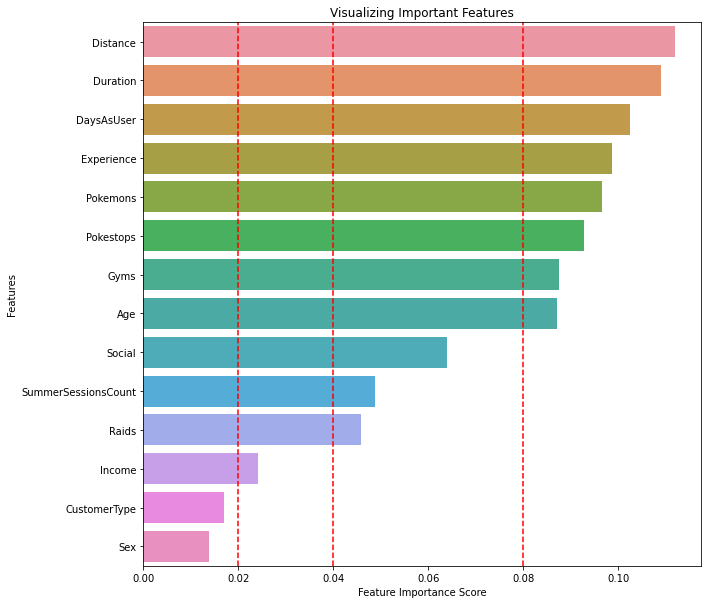

In [128]:
#Visualizing Important Features

%matplotlib inline
# Creating a bar plot
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
[plt.axvline(x=i, linestyle='--', c = 'red') for i in [.020,.040,.080]]

plt.show()

We have some different thresholds on which we could select our top features:

  * 20% - top 12 features
  * 40% - top 11 features
  * 80% - top 8 features

We will create a for loop that will train and test our data on each of our threshold options listed above and add them to our results table.

In [129]:
#sorting features by importance
feat_sorted_idx = np.argsort(feature_imp)

In [130]:
# Choosing most important top 8,11,and 12 features.
top8_feat = X.columns[feat_sorted_idx][-8:]
top11_feat = X.columns[feat_sorted_idx][-11:]
top12_feat = X.columns[feat_sorted_idx][-12:]

top8_feat, top11_feat, top12_feat

(Index(['Gyms', 'Pokestops', 'Experience', 'SummerSessionsCount', 'Income',
        'Age', 'Sex', 'CustomerType'],
       dtype='object'),
 Index(['Pokemons', 'Social', 'Raids', 'Gyms', 'Pokestops', 'Experience',
        'SummerSessionsCount', 'Income', 'Age', 'Sex', 'CustomerType'],
       dtype='object'),
 Index(['Distance', 'Pokemons', 'Social', 'Raids', 'Gyms', 'Pokestops',
        'Experience', 'SummerSessionsCount', 'Income', 'Age', 'Sex',
        'CustomerType'],
       dtype='object'))

----------Random forest model on train set with 8 most important features-------
RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_split=5,
                       n_estimators=2000, random_state=10)
Train - F1: 1.0
Test - F1: 0.8582
Train - Avg Precision: 1.0
Test - Avg Precision: 0.7995
Train - Accuracy: 1.0
Test - Accuracy: 0.8582
Validation - Classification report
               precision    recall  f1-score   support

           0       0.86      0.86      0.86       881
           1       0.85      0.86      0.85       833

    accuracy                           0.86      1714
   macro avg       0.86      0.86      0.86      1714
weighted avg       0.86      0.86      0.86      1714



<Figure size 648x648 with 0 Axes>

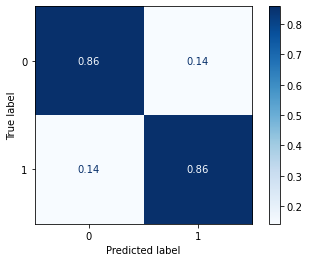

----------Random forest model on train set with 11 most important features-------
RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_split=5,
                       n_estimators=2000, random_state=10)
Train - F1: 1.0
Test - F1: 0.8675
Train - Avg Precision: 1.0
Test - Avg Precision: 0.8229
Train - Accuracy: 1.0
Test - Accuracy: 0.8676
Validation - Classification report
               precision    recall  f1-score   support

           0       0.86      0.88      0.87       856
           1       0.88      0.85      0.87       858

    accuracy                           0.87      1714
   macro avg       0.87      0.87      0.87      1714
weighted avg       0.87      0.87      0.87      1714



<Figure size 648x648 with 0 Axes>

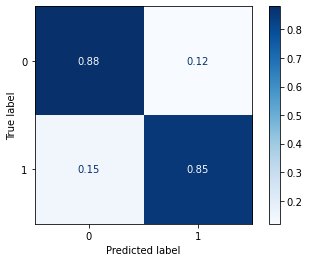

----------Random forest model on train set with 12 most important features-------
RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_split=5,
                       n_estimators=2000, random_state=10)
Train - F1: 1.0
Test - F1: 0.889
Train - Avg Precision: 1.0
Test - Avg Precision: 0.852
Train - Accuracy: 1.0
Test - Accuracy: 0.8891
Validation - Classification report
               precision    recall  f1-score   support

           0       0.87      0.92      0.89       874
           1       0.91      0.85      0.88       840

    accuracy                           0.89      1714
   macro avg       0.89      0.89      0.89      1714
weighted avg       0.89      0.89      0.89      1714



<Figure size 648x648 with 0 Axes>

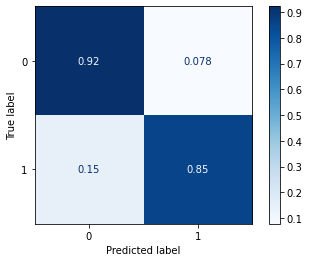

In [131]:
def selecting_features():
    for columns_set in [top8_feat, top11_feat, top12_feat]:
        Xf = X_over[columns_set]
        X_train, X_test, y_train, y_test = train_test_split(Xf, y_over, test_size = 0.25)
        print('----------Random forest model on train set with {} most important features-------'.format(len(columns_set)))
        for rfc_model in [rfc_tuned]:
            print(rfc_model)
            rfc_model.fit(X_train, y_train)
            y_pred = rfc_model.predict(X_test)
            
            y_tr_pred = rfc_model.predict(X_train)
    

            
            train_avgprecision = round(average_precision_score(y_train, y_tr_pred),4)
            test_avgprecision = round(average_precision_score(y_test, y_pred),4)
            train_acc = round(accuracy_score(y_train,y_tr_pred),4)
            test_acc = round(accuracy_score(y_test,y_pred),4)
            train_f1 = round(f1_score(y_train, y_tr_pred, average='weighted'),4)
            test_f1 = round(f1_score(y_test, y_pred, average='weighted'),4)
    
            yhat = rfc_model.predict_proba(X_test)
            pos_probsm = yhat[:, 1]
            # calculate the precision-recall auc
            precision, recall, _ = precision_recall_curve(y_test, pos_probsm)
            auc_scorem = auc(recall, precision)
            #print(model, 'PR AUC: %.3f' % auc_scorem)
    
            print("Train - F1:", train_f1)
            print("Test - F1:", test_f1)
            print("Train - Avg Precision:", train_avgprecision)
            print("Test - Avg Precision:", test_avgprecision)
            print("Train - Accuracy:", train_acc)
            print("Test - Accuracy:", test_acc)

    
    
            print('Validation - Classification report\n', classification_report(y_test,y_pred))
            plt.figure(figsize=(9,9))
            plot_confusion_matrix(rfc_model, X_test, y_test, normalize='true', cmap = 'Blues')
            plt.show()
    
            name = 'RandomForest Tuned with top {} features'.format(len(columns_set))
        
            new_row = {'model':rfc_model,
               'name': name,
               'train_accuracy': train_acc,
               'test_accuracy': test_acc,
               'train_f1': train_f1,
               'test_f1': test_f1,
               'train_avgprecision' : train_avgprecision,
               'test_avgprecision': test_avgprecision,
               'PR AUC': auc_scorem
              }
            results.loc[0 if pd.isnull(results.index.max()) else results.index.max() + 1] = new_row
            
           
            
            
            
selecting_features()

In [132]:
results.sort_values('test_f1', ascending = False).head(25)

,model,name,train_accuracy,test_accuracy,train_f1,test_f1,train_avgprecision,test_avgprecision,PR AUC
14,"(DecisionTreeClassifier(max_depth=80, max_features='auto', min_samples_split=5,\n ...",RandomForest Tuned with top 12 features,1.0000,0.8891,1.0000,0.8890,1.0000,0.8520,0.950230
11,"RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=10),\n ...",Random Forest Tuned,1.0000,0.8821,1.0000,0.8821,1.0000,0.8510,0.956608
13,"(DecisionTreeClassifier(max_depth=80, max_features='auto', min_samples_split=5,\n ...",RandomForest Tuned with top 11 features,1.0000,0.8676,1.0000,0.8675,1.0000,0.8229,0.951072
12,"(DecisionTreeClassifier(max_depth=80, max_features='auto', min_samples_split=5,\n ...",RandomForest Tuned with top 8 features,1.0000,0.8582,1.0000,0.8582,1.0000,0.7995,0.947236
1,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",RandomForest OOTB,1.0000,0.8524,1.0000,0.8522,1.0000,0.8010,0.956510
3,<catboost.core.CatBoostClassifier object at 0x7fdce86245e0>,CatBoost OOTB,0.9125,0.7468,0.9124,0.7460,0.8697,0.6876,0.831797
4,KNeighborsClassifier(n_neighbors=2),KNN with 2 neighbors,0.9518,0.7071,0.9516,0.7068,0.9510,0.6617,0.802276
5,KNeighborsClassifier(n_neighbors=3),KNN with 3 neighbors,0.8554,0.6797,0.8544,0.6759,0.7834,0.6259,0.757131
6,KNeighborsClassifier(),KNN with 5 neighbors,0.7685,0.6359,0.7675,0.6342,0.6949,0.5948,0.684399
2,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n random_sta...",GradientBoost OOTB,0.7119,0.6330,0.7118,0.6326,0.6461,0.5943,0.665188


It looks like reducing the number of features helped our model. Based on the table, the highest perfroming model is now our RandomForest Tuned model using the Top 12 Features.

<a class="anchor" id="cattuned"></a>

#### Hyperparameter tuning Catboost Model

In [133]:
cat.get_params()

{'verbose': False, 'eval_metric': 'F1'}

In [134]:
param_grid = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200]
          
          }

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters based on Randomized Search CV: {'learning_rate': 0.01, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 9, 'border_count': 50}
Best score:  0.7761557236632931
Train - F1: 0.9959
Test - F1: 0.8198
Train - Avg Precision: 0.9932
Test - Avg Precision: 0.7609
Train - Accuracy: 0.9959
Test - Accuracy: 0.8203
Validation - Classification report
               precision    recall  f1-score   support

           0       0.85      0.77      0.81       836
           1       0.80      0.87      0.83       878

    accuracy                           0.82      1714
   macro avg       0.82      0.82      0.82      1714
weighted avg       0.82      0.82      0.82      1714



<Figure size 648x648 with 0 Axes>

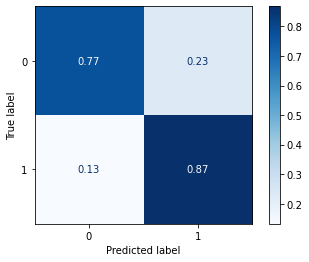

Precision-Recall Curve

No Skill PR AUC: 0.648
Fitting 3 folds for each of 100 candidates, totalling 300 fits
RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fdce86245e0>,
                   n_iter=100, n_jobs=-1,
                   param_distributions={'border_count': [32, 5, 10, 20, 50, 100,
                                                         200],
                                        'depth': [3, 1, 2, 6, 4, 5, 7, 8, 9,
                                                  10],
                                        'iterations': [250, 100, 500, 1000],
                                        'l2_leaf_reg': [3, 1, 5, 10, 100],
                                        'learning_rate': [0.03, 0.001, 0.01,
                                                          0.1, 0.2, 0.3]},
                   random_state=10, scoring='f1_weighted', verbose=10) PR AUC: 0.928


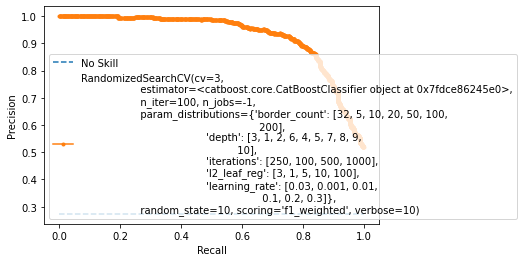

In [135]:
rand_cv(cat, param_grid, 'Catboost Tuned')


In [136]:
cat_tuned = CatBoostClassifier(learning_rate= 0.1, l2_leaf_reg = 3, iterations= 1000, depth= 10, border_count= 32, eval_metric = 'F1', verbose=False)
cat_tuned.fit(X_train, y_train)

In [137]:
#save_scores(cat_tuned, 'CatBoost Tuned')

In [138]:
results.sort_values('test_f1', ascending = False).head(25)

,model,name,train_accuracy,test_accuracy,train_f1,test_f1,train_avgprecision,test_avgprecision,PR AUC
14,"(DecisionTreeClassifier(max_depth=80, max_features='auto', min_samples_split=5,\n ...",RandomForest Tuned with top 12 features,1.0000,0.8891,1.0000,0.8890,1.0000,0.8520,0.950230
11,"RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=10),\n ...",Random Forest Tuned,1.0000,0.8821,1.0000,0.8821,1.0000,0.8510,0.956608
13,"(DecisionTreeClassifier(max_depth=80, max_features='auto', min_samples_split=5,\n ...",RandomForest Tuned with top 11 features,1.0000,0.8676,1.0000,0.8675,1.0000,0.8229,0.951072
12,"(DecisionTreeClassifier(max_depth=80, max_features='auto', min_samples_split=5,\n ...",RandomForest Tuned with top 8 features,1.0000,0.8582,1.0000,0.8582,1.0000,0.7995,0.947236
1,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",RandomForest OOTB,1.0000,0.8524,1.0000,0.8522,1.0000,0.8010,0.956510
15,"RandomizedSearchCV(cv=3,\n estimator=<catboost.core.CatBoostClassifier object ...",Catboost Tuned,0.9959,0.8203,0.9959,0.8198,0.9932,0.7609,0.928150
3,<catboost.core.CatBoostClassifier object at 0x7fdce86245e0>,CatBoost OOTB,0.9125,0.7468,0.9124,0.7460,0.8697,0.6876,0.831797
4,KNeighborsClassifier(n_neighbors=2),KNN with 2 neighbors,0.9518,0.7071,0.9516,0.7068,0.9510,0.6617,0.802276
5,KNeighborsClassifier(n_neighbors=3),KNN with 3 neighbors,0.8554,0.6797,0.8544,0.6759,0.7834,0.6259,0.757131
6,KNeighborsClassifier(),KNN with 5 neighbors,0.7685,0.6359,0.7675,0.6342,0.6949,0.5948,0.684399


#### CatBoost Tuned Feature Selection

In [139]:
#Finding Important Features:
feature_imp = pd.Series(cat_tuned.feature_importances_,index=X.columns).sort_values(ascending=False)


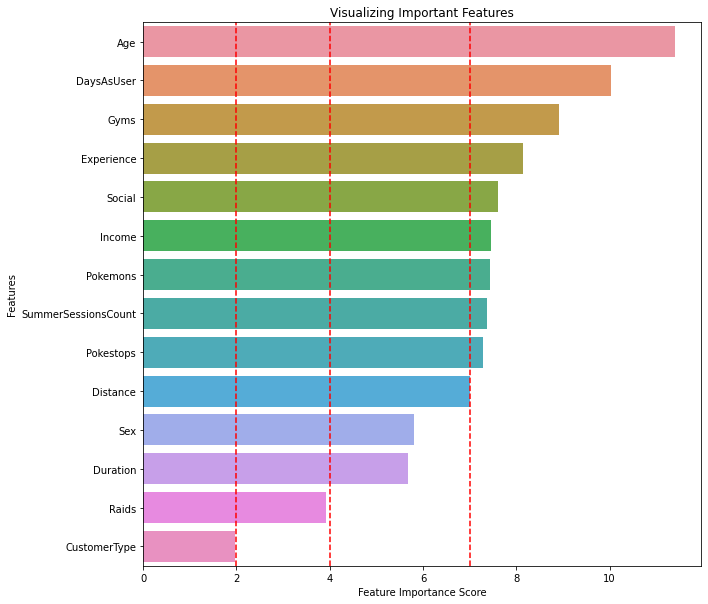

In [140]:
#Visualizing Important Features

%matplotlib inline
# Creating a bar plot
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
[plt.axvline(x=i, linestyle='--', c = 'red') for i in [2.0,4.0,7.0]]

plt.show()

We have some different thresholds on which we could select our top features:

  * 20% - All features
  * 40% - top 13 features
  * 70% - top 8 features

We will create a for loop that will train and test our data on each of our threshold options listed above and add them to our results table.

In [141]:
#sorting features by importance
feat_sorted_idx = np.argsort(feature_imp)

In [142]:
# Choosing most important top 11,13,and 17 features.
top8_feat = X.columns[feat_sorted_idx][-8:]
top13_feat = X.columns[feat_sorted_idx][-13:]

top8_feat, top13_feat

(Index(['Gyms', 'Pokestops', 'Experience', 'SummerSessionsCount', 'Income',
        'Age', 'Sex', 'CustomerType'],
       dtype='object'),
 Index(['Duration', 'Distance', 'Pokemons', 'Social', 'Raids', 'Gyms',
        'Pokestops', 'Experience', 'SummerSessionsCount', 'Income', 'Age',
        'Sex', 'CustomerType'],
       dtype='object'))

----------CatBoost model on train set with 8 most important features-------
Train - F1: 1.0
Test - F1: 0.8289
Train - Avg Precision: 1.0
Test - Avg Precision: 0.7562
Train - Accuracy: 1.0
Test - Accuracy: 0.8291
Validation - Classification report
               precision    recall  f1-score   support

           0       0.87      0.79      0.83       881
           1       0.80      0.87      0.83       833

    accuracy                           0.83      1714
   macro avg       0.83      0.83      0.83      1714
weighted avg       0.83      0.83      0.83      1714



<Figure size 648x648 with 0 Axes>

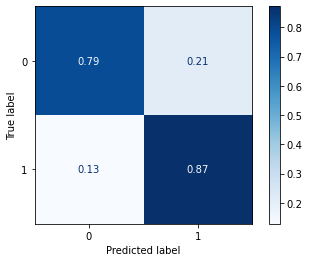

----------CatBoost model on train set with 13 most important features-------
Train - F1: 1.0
Test - F1: 0.8341
Train - Avg Precision: 1.0
Test - Avg Precision: 0.7735
Train - Accuracy: 1.0
Test - Accuracy: 0.8343
Validation - Classification report
               precision    recall  f1-score   support

           0       0.86      0.80      0.83       853
           1       0.82      0.87      0.84       861

    accuracy                           0.83      1714
   macro avg       0.84      0.83      0.83      1714
weighted avg       0.84      0.83      0.83      1714



<Figure size 648x648 with 0 Axes>

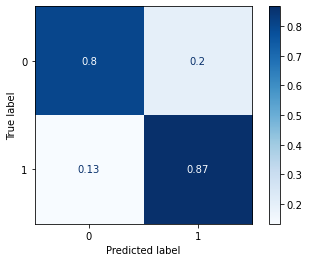

In [143]:
def selecting_features():
    for columns_set in [top8_feat, top13_feat]:
        Xf = X_over[columns_set]
        X_train, X_test, y_train, y_test = train_test_split(Xf, y_over, test_size = 0.25)
        print('----------CatBoost model on train set with {} most important features-------'.format(len(columns_set)))
        for cat_model in [cat_tuned]:
            print(cat_model)
            cat_model.fit(X_train, y_train)
            y_pred = cat_model.predict(X_test)
            
            y_tr_pred = cat_model.predict(X_train)
    

            
            train_avgprecision = round(average_precision_score(y_train, y_tr_pred),4)
            test_avgprecision = round(average_precision_score(y_test, y_pred),4)
            train_acc = round(accuracy_score(y_train,y_tr_pred),4)
            test_acc = round(accuracy_score(y_test,y_pred),4)
            train_f1 = round(f1_score(y_train, y_tr_pred, average='weighted'),4)
            test_f1 = round(f1_score(y_test, y_pred, average='weighted'),4)
    
            yhat = cat_model.predict_proba(X_test)
            pos_probsm = yhat[:, 1]
            # calculate the precision-recall auc
            precision, recall, _ = precision_recall_curve(y_test, pos_probsm)
            auc_scorem = auc(recall, precision)
            #print(model, 'PR AUC: %.3f' % auc_scorem)
    
            print("Train - F1:", train_f1)
            print("Test - F1:", test_f1)
            print("Train - Avg Precision:", train_avgprecision)
            print("Test - Avg Precision:", test_avgprecision)
            print("Train - Accuracy:", train_acc)
            print("Test - Accuracy:", test_acc)

    
    
            print('Validation - Classification report\n', classification_report(y_test,y_pred))
            plt.figure(figsize=(9,9))
            plot_confusion_matrix(cat_model, X_test, y_test, normalize='true', cmap = 'Blues')
            plt.show()
    
            name = 'CatBoost Tuned with top {} features'.format(len(columns_set))
        
            new_row = {'model':cat_model,
               'name': name,
               'train_accuracy': train_acc,
               'test_accuracy': test_acc,
               'train_f1': train_f1,
               'test_f1': test_f1,
               'train_avgprecision' : train_avgprecision,
               'test_avgprecision': test_avgprecision,
               'PR AUC': auc_scorem
              }
            results.loc[0 if pd.isnull(results.index.max()) else results.index.max() + 1] = new_row
            
           
            
            
            
selecting_features()

In [144]:
results.sort_values('test_f1', ascending = False).head(25)

,model,name,train_accuracy,test_accuracy,train_f1,test_f1,train_avgprecision,test_avgprecision,PR AUC
14,"(DecisionTreeClassifier(max_depth=80, max_features='auto', min_samples_split=5,\n ...",RandomForest Tuned with top 12 features,1.0000,0.8891,1.0000,0.8890,1.0000,0.8520,0.950230
11,"RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=10),\n ...",Random Forest Tuned,1.0000,0.8821,1.0000,0.8821,1.0000,0.8510,0.956608
13,"(DecisionTreeClassifier(max_depth=80, max_features='auto', min_samples_split=5,\n ...",RandomForest Tuned with top 11 features,1.0000,0.8676,1.0000,0.8675,1.0000,0.8229,0.951072
12,"(DecisionTreeClassifier(max_depth=80, max_features='auto', min_samples_split=5,\n ...",RandomForest Tuned with top 8 features,1.0000,0.8582,1.0000,0.8582,1.0000,0.7995,0.947236
1,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",RandomForest OOTB,1.0000,0.8524,1.0000,0.8522,1.0000,0.8010,0.956510
17,<catboost.core.CatBoostClassifier object at 0x7fdcea0ab6d0>,CatBoost Tuned with top 13 features,1.0000,0.8343,1.0000,0.8341,1.0000,0.7735,0.942874
16,<catboost.core.CatBoostClassifier object at 0x7fdcea0ab6d0>,CatBoost Tuned with top 8 features,1.0000,0.8291,1.0000,0.8289,1.0000,0.7562,0.935756
15,"RandomizedSearchCV(cv=3,\n estimator=<catboost.core.CatBoostClassifier object ...",Catboost Tuned,0.9959,0.8203,0.9959,0.8198,0.9932,0.7609,0.928150
3,<catboost.core.CatBoostClassifier object at 0x7fdce86245e0>,CatBoost OOTB,0.9125,0.7468,0.9124,0.7460,0.8697,0.6876,0.831797
4,KNeighborsClassifier(n_neighbors=2),KNN with 2 neighbors,0.9518,0.7071,0.9516,0.7068,0.9510,0.6617,0.802276


Our CatBoost model with all features seemed to do the best but slightly underperformed the best Random Forest Models

<a class="anchor" id="modelselection"></a>

### Model Selection

In [145]:
results.sort_values('test_f1', ascending = False).head(25)

,model,name,train_accuracy,test_accuracy,train_f1,test_f1,train_avgprecision,test_avgprecision,PR AUC
14,"(DecisionTreeClassifier(max_depth=80, max_features='auto', min_samples_split=5,\n ...",RandomForest Tuned with top 12 features,1.0000,0.8891,1.0000,0.8890,1.0000,0.8520,0.950230
11,"RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=10),\n ...",Random Forest Tuned,1.0000,0.8821,1.0000,0.8821,1.0000,0.8510,0.956608
13,"(DecisionTreeClassifier(max_depth=80, max_features='auto', min_samples_split=5,\n ...",RandomForest Tuned with top 11 features,1.0000,0.8676,1.0000,0.8675,1.0000,0.8229,0.951072
12,"(DecisionTreeClassifier(max_depth=80, max_features='auto', min_samples_split=5,\n ...",RandomForest Tuned with top 8 features,1.0000,0.8582,1.0000,0.8582,1.0000,0.7995,0.947236
1,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",RandomForest OOTB,1.0000,0.8524,1.0000,0.8522,1.0000,0.8010,0.956510
17,<catboost.core.CatBoostClassifier object at 0x7fdcea0ab6d0>,CatBoost Tuned with top 13 features,1.0000,0.8343,1.0000,0.8341,1.0000,0.7735,0.942874
16,<catboost.core.CatBoostClassifier object at 0x7fdcea0ab6d0>,CatBoost Tuned with top 8 features,1.0000,0.8291,1.0000,0.8289,1.0000,0.7562,0.935756
15,"RandomizedSearchCV(cv=3,\n estimator=<catboost.core.CatBoostClassifier object ...",Catboost Tuned,0.9959,0.8203,0.9959,0.8198,0.9932,0.7609,0.928150
3,<catboost.core.CatBoostClassifier object at 0x7fdce86245e0>,CatBoost OOTB,0.9125,0.7468,0.9124,0.7460,0.8697,0.6876,0.831797
4,KNeighborsClassifier(n_neighbors=2),KNN with 2 neighbors,0.9518,0.7071,0.9516,0.7068,0.9510,0.6617,0.802276


Our highest performing model was the Random Forest Tuned with Top 12 Features.

<a class="anchor" id="fallchurn"></a>

## Predicting Which Fall Players will Churn

Now we will use our top model to predict which of our fall users are likely to churn and the probability of churn. The first step is to create a dataframe with the same features as the summer_features_modeling dataframe used in our predictive models.

In [146]:
#Create Fass Sessions Count DF (will become column in fall_customers dataframe)

FallSessionsCount = fallsessions.groupby('CustomerID').count()
FallSessionsCount = FallSessionsCount.drop(columns=['Date','Experience','Pokestops','Gyms','Raids','Social','Pokemons','Distance','Duration'])

                    
                    

In [147]:
#Create Fall Avgs DF with the average play factors (will become columns in fall_customers dataframe)
fall_avgs = fallsessions.groupby('CustomerID').mean()

In [148]:
#merge SummerSessionsCount df with customer df to create summer_users df
fall_users = customerdata.merge(FallSessionsCount, on='CustomerID', how='right')

#merge summer_avgs to summer_users df
fall_users = fall_users.merge(fall_avgs, on='CustomerID', how='right')

In [149]:
#drop PlayID_y column (this column is the average PlayID which is useless)
fall_users = fall_users.drop(columns='PlayID_y')

In [150]:
#rename PlayID_x (which is the number of times the customer played in the summer)
fall_users = fall_users.rename(columns={"PlayID_x":"SummerSessionsCount"})

In [151]:
fall_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3603 entries, 0 to 3602
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           3603 non-null   int64  
 1   CustomerType         3603 non-null   int64  
 2   Registrationdate     3603 non-null   object 
 3   Sex                  3603 non-null   int64  
 4   Age                  3603 non-null   int64  
 5   fallbonus            3603 non-null   int64  
 6   Income               3603 non-null   int64  
 7   SummerSessionsCount  3603 non-null   int64  
 8   Experience           3603 non-null   float64
 9   Pokestops            3603 non-null   float64
 10  Gyms                 3603 non-null   float64
 11  Raids                3603 non-null   float64
 12  Social               3603 non-null   float64
 13  Pokemons             3603 non-null   float64
 14  Distance             3603 non-null   float64
 15  Duration             3603 non-null   f

The last Column we need is the DasAsUsers column which is created from the Registrationdate column.

#### Create DaysAsUsers Column and completed fall_features df

In [152]:
fall_users['Registrationdate']= pd.to_datetime(fall_users['Registrationdate'])

In [153]:
fall_features = fall_users

In [154]:
#create DaysAsUser DataFrame
DaysAsUser = fall_features.groupby(['CustomerID']).agg({
    'Registrationdate' : lambda x: (snapshot_date - x.max()).days}).reset_index()

DaysAsUser.rename(columns = {'Registrationdate': 'DaysAsUser'}, inplace=True)

In [155]:
#merge DaysAsUser onto summer_features dataframe
fall_features = fall_features.merge(DaysAsUser, on='CustomerID', how='left')

In [156]:
#drop registration date and other unneeded columns
fall_features_modeling = fall_features.drop(columns=['CustomerID','Registrationdate','fallbonus'])

In [157]:
fall_features_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3603 entries, 0 to 3602
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerType         3603 non-null   int64  
 1   Sex                  3603 non-null   int64  
 2   Age                  3603 non-null   int64  
 3   Income               3603 non-null   int64  
 4   SummerSessionsCount  3603 non-null   int64  
 5   Experience           3603 non-null   float64
 6   Pokestops            3603 non-null   float64
 7   Gyms                 3603 non-null   float64
 8   Raids                3603 non-null   float64
 9   Social               3603 non-null   float64
 10  Pokemons             3603 non-null   float64
 11  Distance             3603 non-null   float64
 12  Duration             3603 non-null   float64
 13  DaysAsUser           3603 non-null   int64  
dtypes: float64(8), int64(6)
memory usage: 422.2 KB


In [158]:
Xfall = fall_features_modeling
Xfall.shape

(3603, 14)

Now that our dataframe is ready with the correct features, we will apply sklearn's StandardScaler and then fit our new data to our model.

In [159]:
scaler = StandardScaler()
scaler.fit(Xfall)
Xfall_scaled = scaler.transform(Xfall)

In [160]:
rfc_tuned = RandomForestClassifier(n_estimators= 2000, min_samples_split= 5, min_samples_leaf= 1, max_features= 'auto', max_depth= 80, bootstrap= False,random_state=10)
rfc_tuned.fit(X_train, y_train)
y_pred = rfc_tuned.predict(Xfall_scaled)
proba = rfc_tuned.predict_proba(Xfall_scaled)[:,1]

Let's add our predictions back to the original fall_features dataframe so that we have the customer ID's available.

In [161]:
fall_features['ChurnPredictions'] = y_pred

In [162]:
fall_features['ChurnPredictions'].value_counts()

0    3313
1     290
Name: ChurnPredictions, dtype: int64

Based off our model, there are 281 users that are likely to churn. 

Finally, the best way to use this model is assigning Churn Probability for each customer. Let's get the churn probability from our model. We will create a column called ChurnProbability and then look at the probabilities for our customers that are predicted to churn (probability higher than .5).

In [163]:
fall_features['ChurnProbability'] = proba

In [164]:
fall_features_churn = fall_features[fall_features.ChurnPredictions == 1]
fall_features_churn[['CustomerID','ChurnProbability']].sample(15)

,CustomerID,ChurnProbability
2489,3464,0.654167
743,1056,0.593000
106,140,0.511750
305,424,0.534625
2783,3849,0.560500
1729,2394,0.528667
2976,4127,0.528333
1077,1497,0.500750
2460,3426,0.560750
3036,4205,0.528542


In [165]:
fall_features_churn.describe()

,CustomerID,CustomerType,Sex,Age,fallbonus,Income,SummerSessionsCount,Experience,Pokestops,Gyms,Raids,Social,Pokemons,Distance,Duration,DaysAsUser,ChurnPredictions,ChurnProbability
count,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.0,290.000000
mean,2518.165517,2.255172,0.431034,25.396552,0.213793,1.831034,1.486207,4051.620690,16.096264,5.765230,0.426724,0.778448,21.332471,4.447243,42.396216,329.465517,1.0,0.554800
std,1462.105121,1.034219,0.496077,10.335781,0.410691,0.812363,0.772460,845.343306,2.232777,2.282437,0.682883,1.026738,9.700750,2.994844,19.180572,203.703429,0.0,0.049277
min,6.000000,1.000000,0.000000,6.000000,0.000000,1.000000,1.000000,2435.000000,11.000000,1.500000,0.000000,0.000000,6.000000,0.873543,14.635875,124.000000,1.0,0.500125
25%,1260.250000,2.000000,0.000000,17.000000,0.000000,1.000000,1.000000,3424.750000,14.500000,4.000000,0.000000,0.000000,14.000000,2.350391,29.156057,163.250000,1.0,0.518396
50%,2524.500000,2.000000,0.000000,26.500000,0.000000,2.000000,1.000000,3942.000000,16.000000,5.500000,0.000000,0.500000,18.000000,3.669201,39.267136,232.500000,1.0,0.540021
75%,3831.250000,2.000000,1.000000,31.000000,0.000000,3.000000,2.000000,4650.000000,17.666667,6.500000,1.000000,1.000000,28.000000,5.386167,50.627063,491.250000,1.0,0.577635
max,4991.000000,4.000000,1.000000,77.000000,1.000000,3.000000,4.000000,6817.500000,24.000000,20.000000,3.000000,6.000000,51.000000,18.038803,138.663188,791.000000,1.0,0.764500


Here we can see the detailed information of our customers who are predicted to churn. The average probability is just under 56% which is pretty low, with the highest being 82%.

<a class="anchor" id="conclusions"></a>

## Conclusions and Recommendations 

### In this project we have successfully: 

* **Segmented our users** into Low, Mid, and High value customers that can be targeted accordingly with appropriate marketing and incentives.

* **Discovered Segment Trends** such as our high value customers tending to be more social players with higher income levels.

* **Calculated the churn rate** of users and uncovered that the biggest indicators of churn are the type of players (social players churning the least) and the value of the customer.

* Proved a statistically significant **effect of the fall bonus** on churn rate

* Created a model to **predict churn rate** with an accuracy of almost 90% and **found the churn probabilities** of our fall users.


### Recommendations 
Incentivise social play- the more social aspects, the higher value the customer and the lower the churn probability.

Create segments based on Churn Probability of current users and build strategies on top of that.

Continue to strategically provide bonuses (via revenue optimization) to players to encourage game play and reduce churn.